# 3.4 CartPoleをQ学習で制御
- パッケージのインストール
```
$ pip install gym
$ pip install matplotlib
$ pip install JSAnimation
$ pip uninstall pyglet -y
$ pip install pyglet==1.2.4
$ conda install -c conda-forge ffmpeg
```

## パッケージのimport

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

## 動画の描画関数の宣言
- 参考URL：[http://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb](http://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb)

In [ ]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)

    anim.save('movie_cartpole.mp4')  # 動画のファイル名と保存です
    display(display_animation(anim, default_mode='loop'))

## 定数の設定

In [ ]:
ENV = 'CartPole-v0'  # 使用する課題名
NUM_DIZITIZED = 6    # 各状態の離散値への分割数
GAMMA = 0.99         # 時間割引率
ETA = 0.5            # 学習係数
MAX_STEPS = 200      # 1試行のstep数
NUM_EPISODES = 1000  # 最大試行回数
DEBUG = True

## class Agent

In [ ]:
class Agent:
    '''CartPoleのエージェントクラスです、棒付き台車そのものになります'''

    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための頭脳を生成

    def update_Q_function(self, observation, action, reward, observation_next):
        '''Q関数の更新'''
        self.brain.update_Q_table(
            observation, action, reward, observation_next)

    def get_action(self, observation, step):
        '''行動の決定'''
        action = self.brain.decide_action(observation, step)
        return action

## class Brain
- 0.5[radian] ≒ 29[°]
- Q関数は1296行x2列となる
  - 状態は6(分割数) ^ 4 = 1296
  - 行動は左か右の2つ

In [ ]:
def bins_(clip_min, clip_max, num):
    '''観測した状態（連続値）を離散値にデジタル変換する閾値を求める'''
    ary = np.linspace(clip_min, clip_max, num + 1)[1:-1]
    print( ary )
    return ary

if DEBUG:
    bins_(-2.4, 2.4, NUM_DIZITIZED)
    bins_(-3.0, 3.0, NUM_DIZITIZED)
    bins_(-0.5, 0.5, NUM_DIZITIZED)
    bins_(-2.0, 2.0, NUM_DIZITIZED)
    print( np.digitize(-1.7, bins=bins_(-2.4, 2.4, NUM_DIZITIZED)) )
    print( np.digitize(-1.5, bins=bins_(-2.4, 2.4, NUM_DIZITIZED)) )

[-1.6 -0.8  0.   0.8  1.6]
[-2. -1.  0.  1.  2.]
[-0.33333333 -0.16666667  0.          0.16666667  0.33333333]
[-1.33333333 -0.66666667  0.          0.66666667  1.33333333]
[-1.6 -0.8  0.   0.8  1.6]
0
[-1.6 -0.8  0.   0.8  1.6]
1


In [ ]:
class Brain:
    '''エージェントが持つ脳となるクラスです、Q学習を実行します'''

    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得

        # Qテーブルを作成。行数は状態を分割数^（4変数）にデジタル変換した値、列数は行動数を示す
        self.q_table = np.random.uniform(low=0, high=1, size=(
            NUM_DIZITIZED**num_states, num_actions))


    def bins(self, clip_min, clip_max, num):
        '''観測した状態（連続値）を離散値にデジタル変換する閾値を求める'''
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]

    def digitize_state(self, observation):
        '''
        観測したobservation状態を、離散値に変換する
        状態を計算して返す
        '''
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
            np.digitize(cart_pos,   bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
            np.digitize(cart_v,     bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
            np.digitize(pole_v,     bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))
        ]
        return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])

    def update_Q_table(self, observation, action, reward, observation_next):
        '''QテーブルをQ学習により更新'''
        state = self.digitize_state(observation)  # 状態を離散化
        state_next = self.digitize_state(observation_next)  # 次の状態を離散化
        Max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + \
            ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])

    def decide_action(self, observation, episode):
        '''ε-greedy法で徐々に最適行動のみを採用する'''
        state = self.digitize_state(observation)
        epsilon = 0.5 * (1 / (episode + 1))

        if np.random.uniform(0, 1) >= epsilon:
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions)  # 0,1の行動をランダムに返す
        return action

## class Environment
- gym.make：OpenAIのゲーム環境を立ち上げる命令
- action：0は左に押す、1は右に押す
- env.step(action)：4つの変数を出力する
  - observation：カートと棒の状態を示す(状態は4つの変数のリスト)
    - カート位置：-2.4～2.4
    - カート速度：-Inf～Inf
    - 棒の角度：-41.8°～41.8°
    - 棒の角速度：-Inf～Inf
  - reward：即時報酬
    - カートの位置が±2.4の範囲にある、もしくは、棒が20.9°以上傾いてない場合は1、それ以外は0
  - done：終了状態になるとTrue、そうでない場合はFalse
    - 終了条件：step数が200を超える
    - 終了条件：カートが±2.4の範囲外
    - 終了条件：棒が20.9°以上傾く
  - info：デバッグに必要な情報を格納している

In [ ]:
if DEBUG:
    env = gym.make( 'CartPole-v0' )
    print( env.observation_space.shape )
    print( env.action_space.shape )
    print( env.action_space.n )
    observation = env.reset()
    print( type(observation), observation.shape, observation )
    observation, reward, done, info = env.step( 0 )
    print( type(observation), observation.shape, observation )
    print( observation )

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
(4,)
()
2
<class 'numpy.ndarray'> (4,) [-0.03004964  0.02356215 -0.01970614  0.00591152]
<class 'numpy.ndarray'> (4,) [-0.0295784  -0.17127173 -0.01958791  0.29231236]
[-0.0295784  -0.17127173 -0.01958791  0.29231236]


In [ ]:
class Environment:
    '''CartPoleを実行する環境のクラスです'''

    def __init__(self):
        self.env    = gym.make(ENV)                        # 実行する課題を設定
        num_states  = self.env.observation_space.shape[0]  # 課題の状態の数4を取得
        num_actions = self.env.action_space.n              # CartPoleの行動（右に左に押す）の2を取得
        self.agent  = Agent(num_states, num_actions)       # 環境内で行動するAgentを生成

    def run(self):
        '''実行'''
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        is_episode_final = False  # 最終試行フラグ
        frames = []  # 動画用に画像を格納する変数

        for episode in range(NUM_EPISODES):  # 試行数分繰り返す
            observation = self.env.reset()  # 環境の初期化

            for step in range(MAX_STEPS):  # 1エピソードのループ

                if is_episode_final is True:  # 最終試行ではframesに各時刻の画像を追加していく
                    frames.append(self.env.render(mode='rgb_array'))

                # 行動を求める
                action = self.agent.get_action(observation, episode)

                # 行動a_tの実行により、s_{t+1}, r_{t+1}を求める
                observation_next, _, done, _ = self.env.step( action )  # rewardとinfoは使わないので_にする

                # 報酬を与える
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    if step < 195:
                        reward = -1  # 途中でこけたら罰則として報酬-1を与える
                        complete_episodes = 0  # 195step以上連続で立ち続けた試行数をリセット
                    else:
                        reward = 1  # 立ったまま終了時は報酬1を与える
                        complete_episodes += 1  # 連続記録を更新
                else:
                    reward = 0  # 途中の報酬は0

                # step+1の状態observation_nextを用いて,Q関数を更新する
                self.agent.update_Q_function(
                    observation, action, reward, observation_next)

                # 観測の更新
                observation = observation_next

                # 終了時の処理
                if done:
                    print('{0} Episode: Finished after {1} time steps'.format(
                        episode, step + 1))
                    break

            if is_episode_final is True:  # 最終試行では動画を保存と描画
                display_frames_as_gif(frames)
                break

            if complete_episodes >= 10:  # 10連続成功なら
                print('10回連続成功')
                is_episode_final = True  # 次の試行を描画を行う最終試行とする

## main

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
0 Episode: Finished after 73 time steps
1 Episode: Finished after 34 time steps
2 Episode: Finished after 21 time steps
3 Episode: Finished after 12 time steps
4 Episode: Finished after 23 time steps
5 Episode: Finished after 46 time steps
6 Episode: Finished after 21 time steps
7 Episode: Finished after 75 time steps
8 Episode: Finished after 14 time steps
9 Episode: Finished after 49 time steps
10 Episode: Finished after 61 time steps
11 Episode: Finished after 39 time steps
12 Episode: Finished after 42 time steps
13 Episode: Finished after 198 time steps
14 Episode: Finished after 45 time steps
15 Episode: Finished after 111 time steps
16 Episode: Finished after 187 time steps
17 Episode: Finished after 36 time steps
18 Episode: Finished after 42 time steps
19 Episode: Finished after 53 time steps
20 Episode: Finished after 115 time steps
21 Episode: Finished after 31 time steps
22 Ep


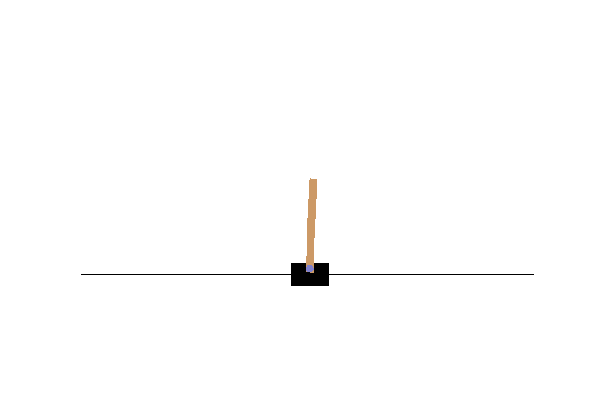
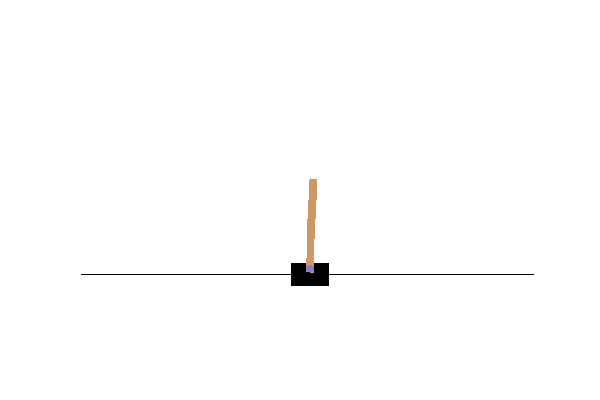
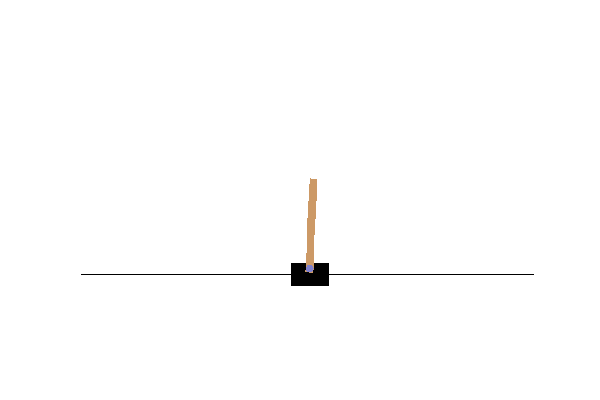
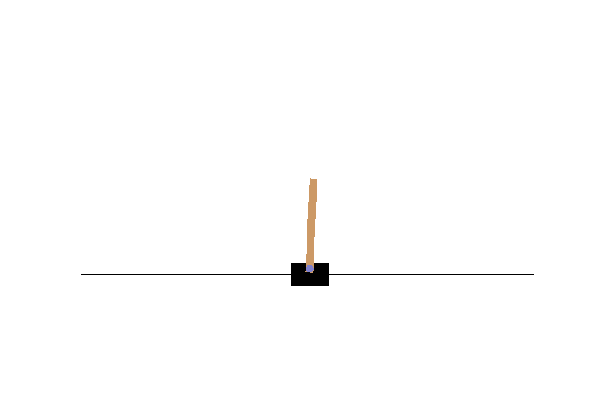
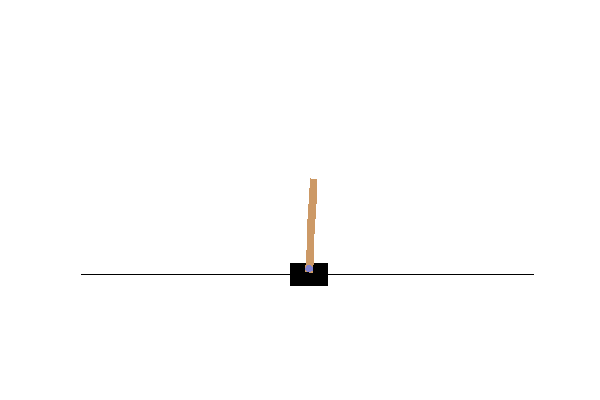
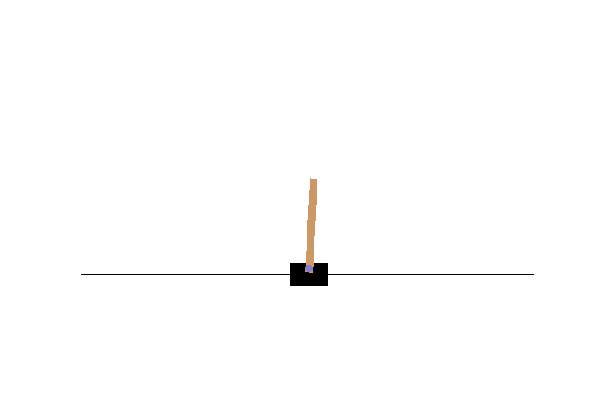
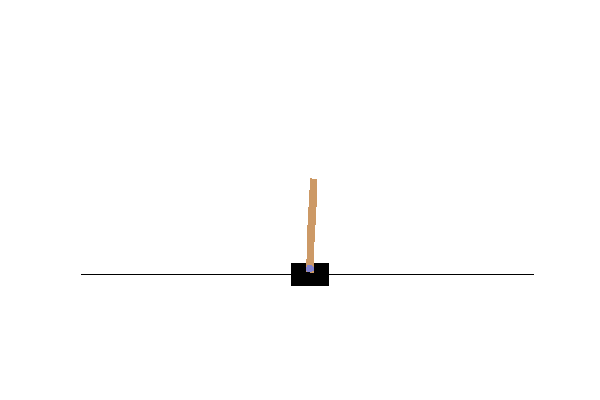
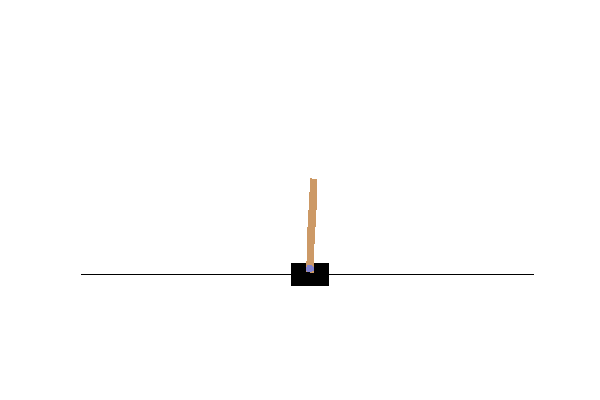
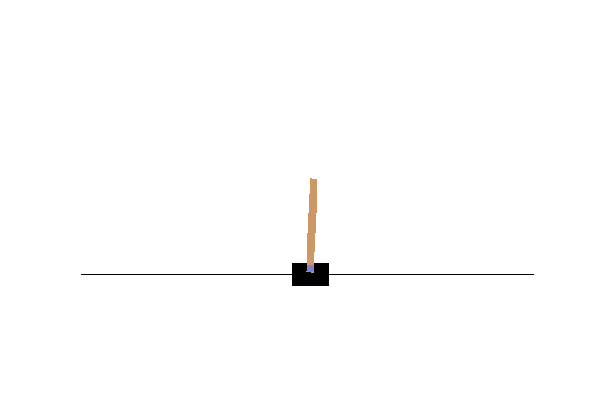
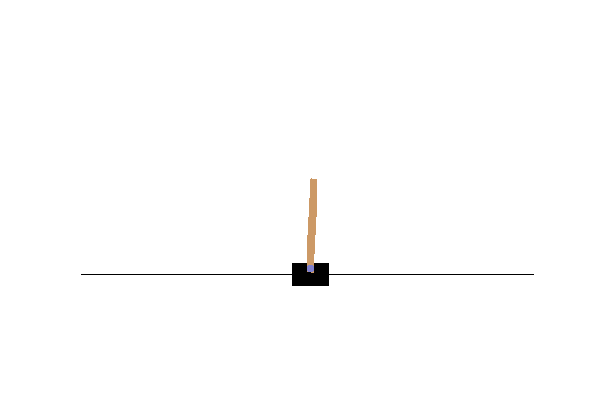
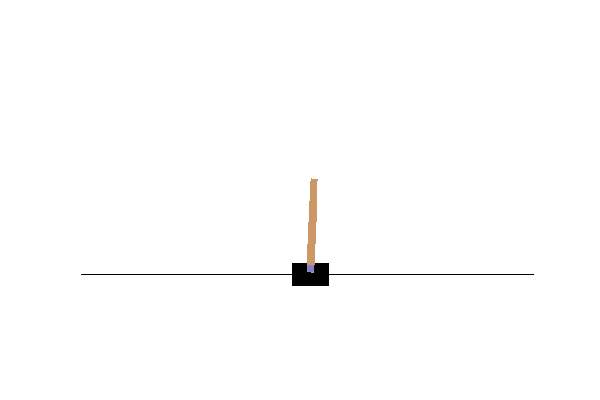
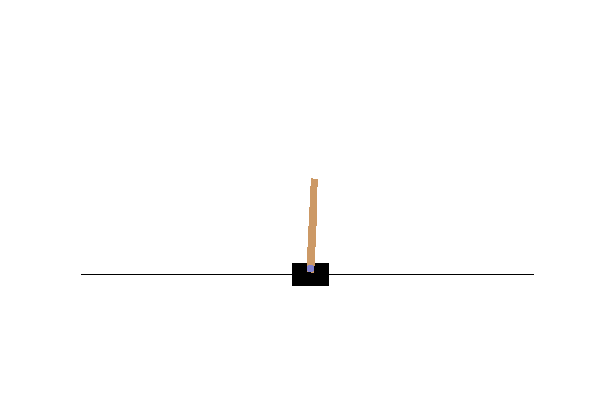
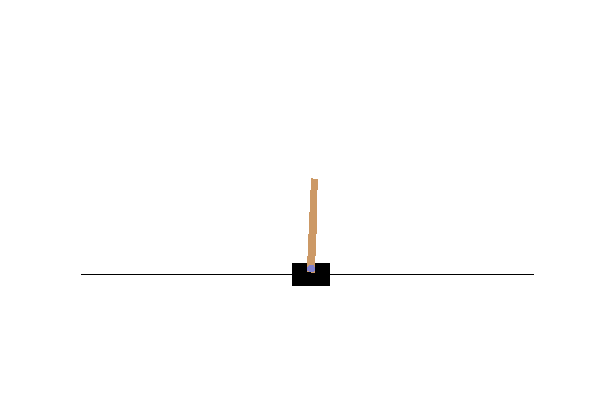
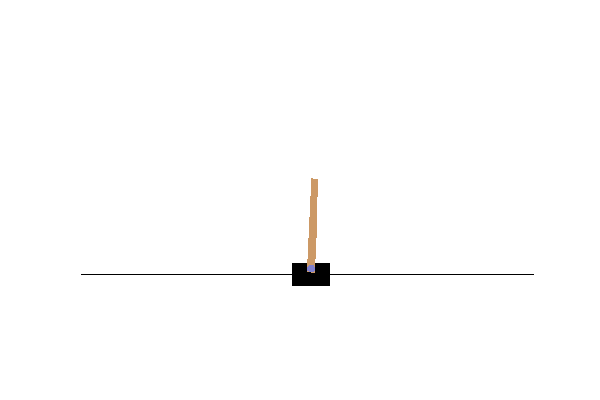
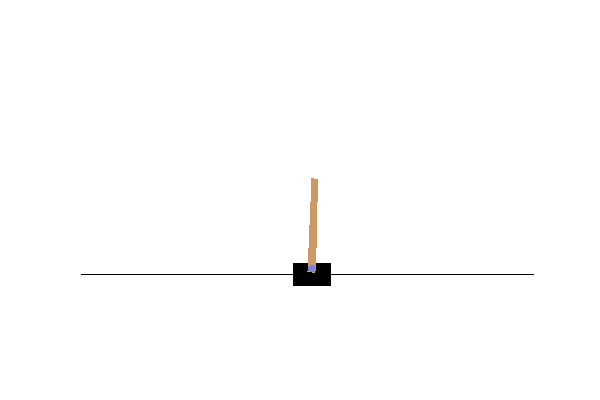
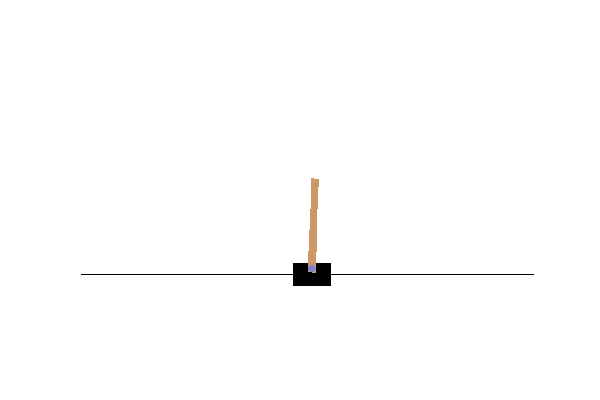
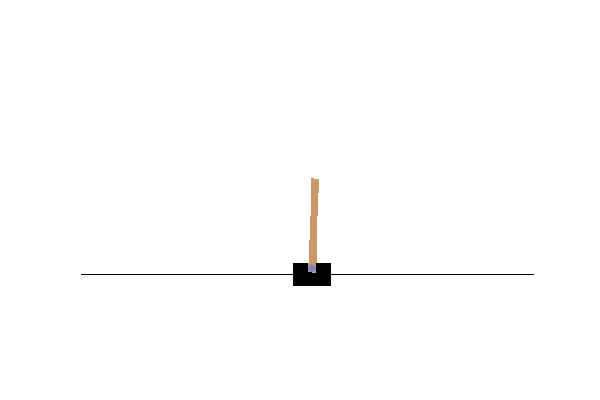
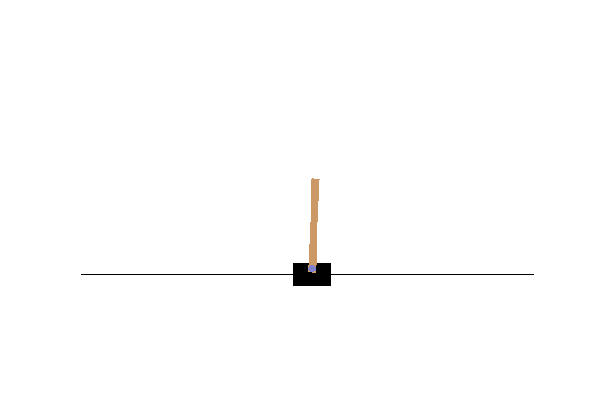
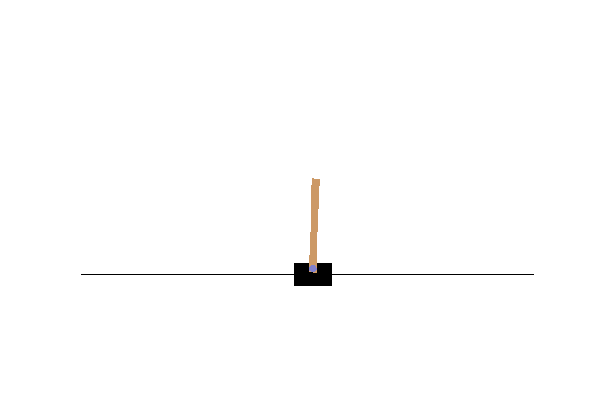
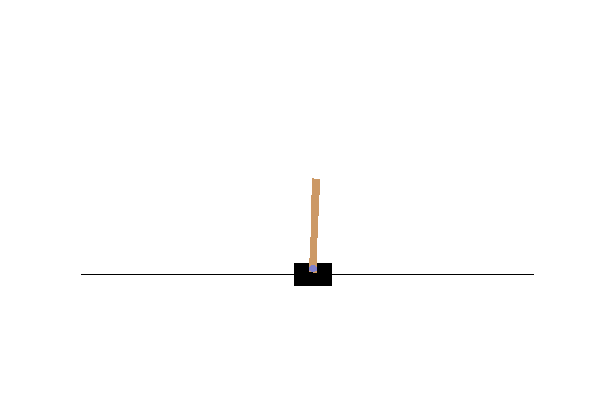
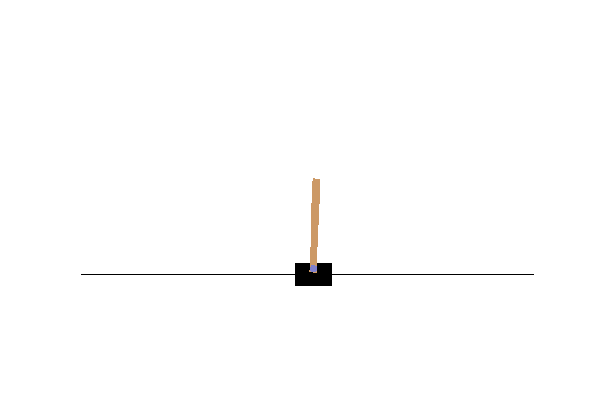
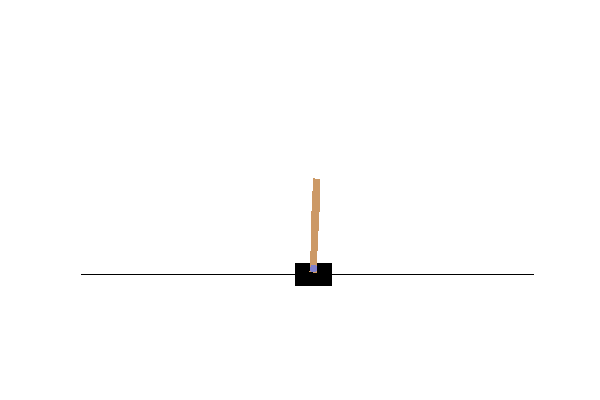
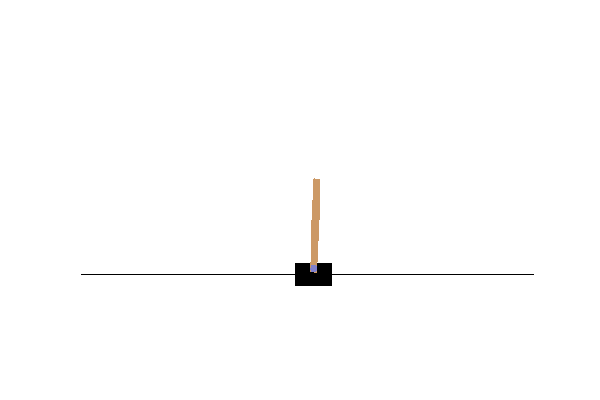
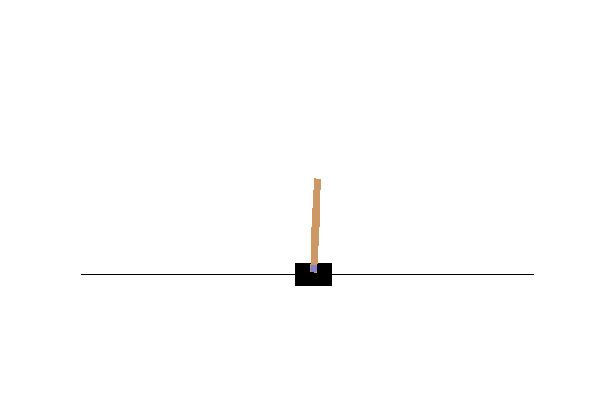
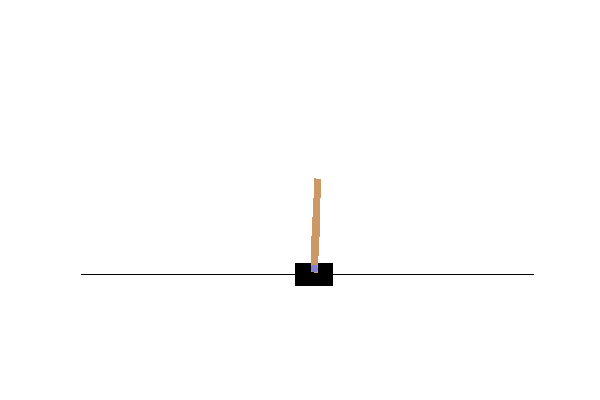
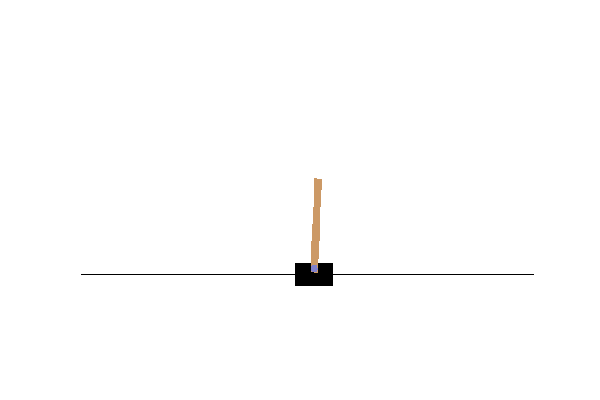
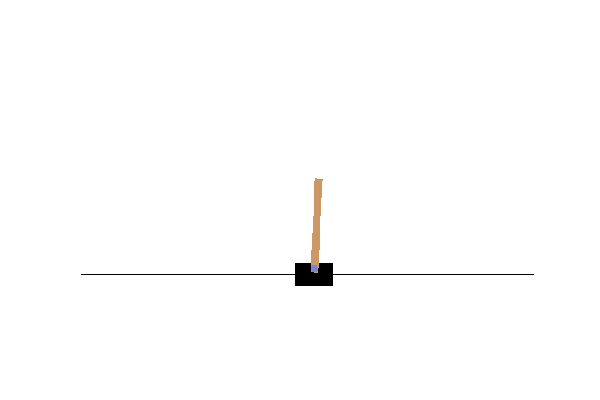
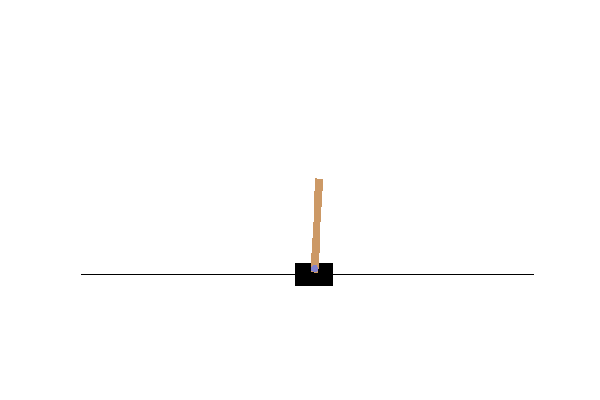
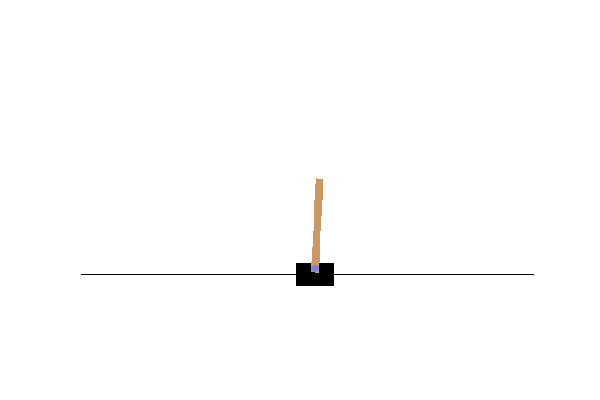
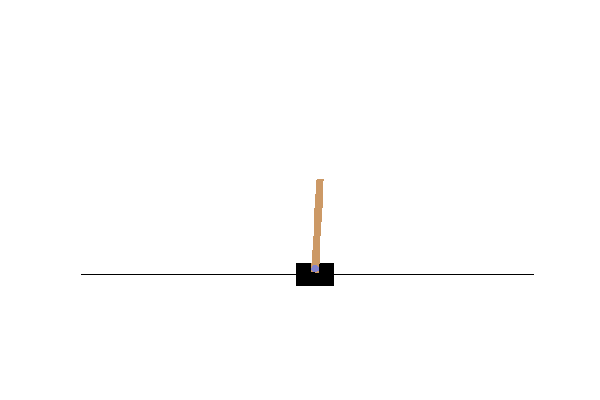
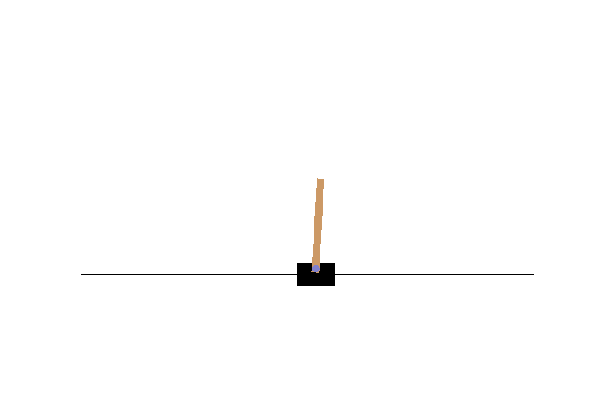
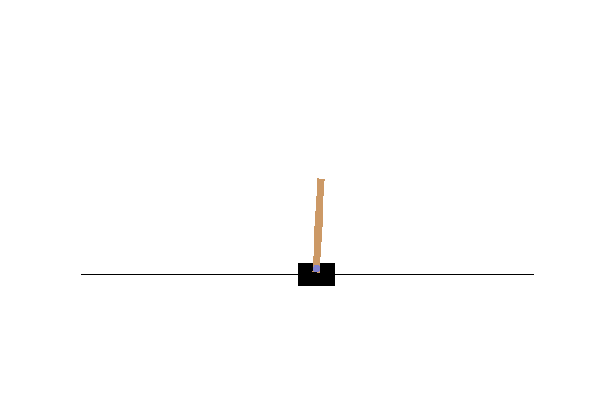
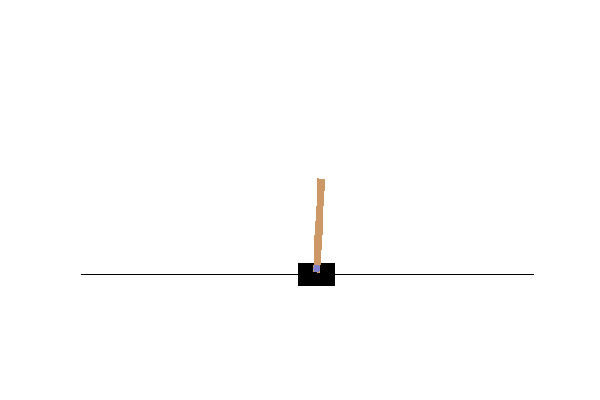
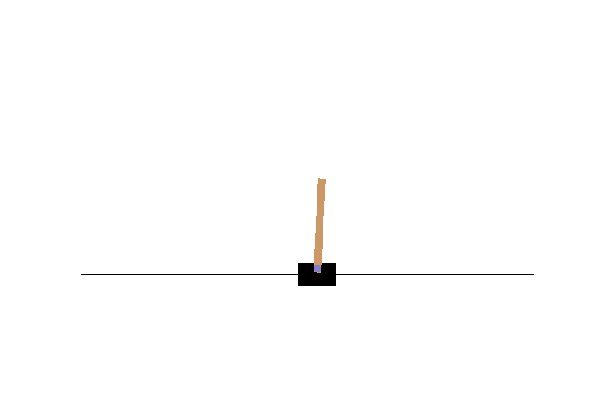
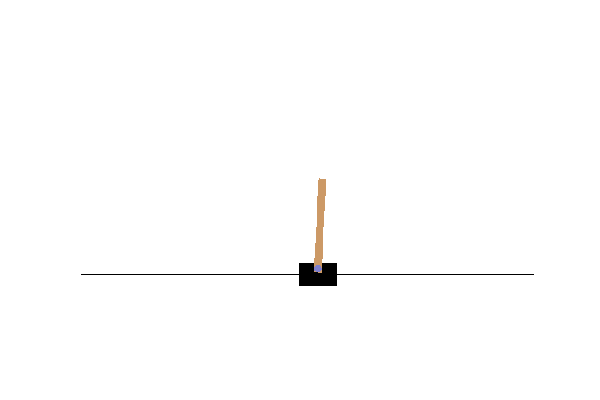
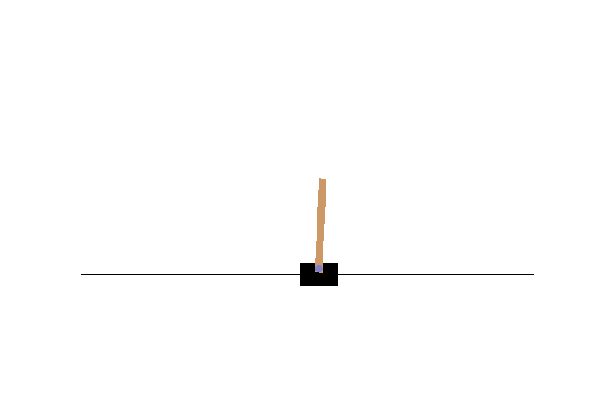
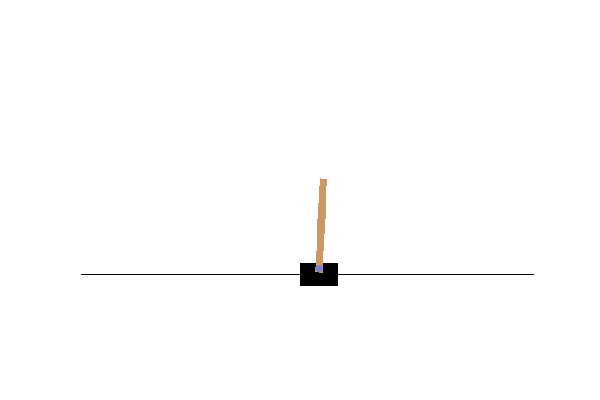
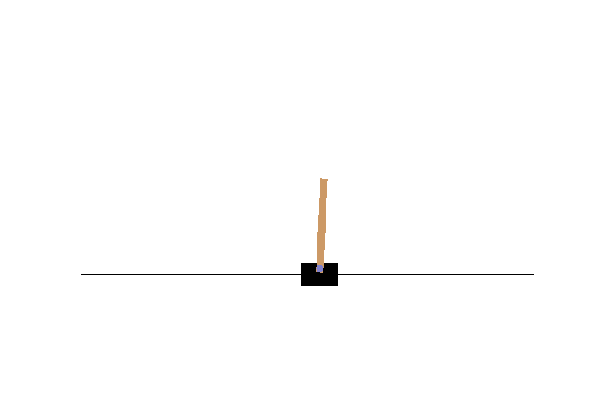
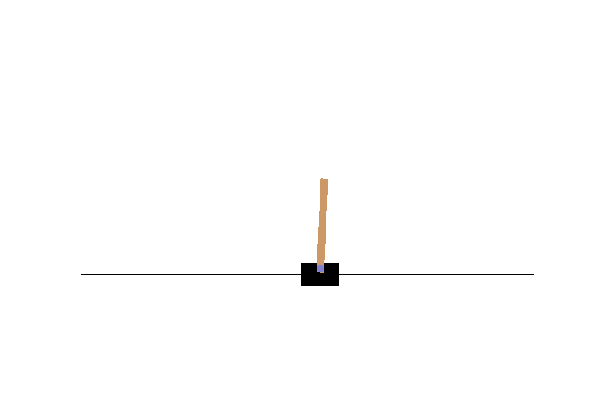
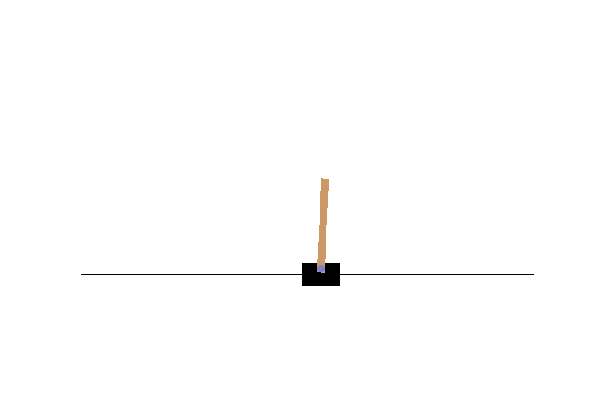
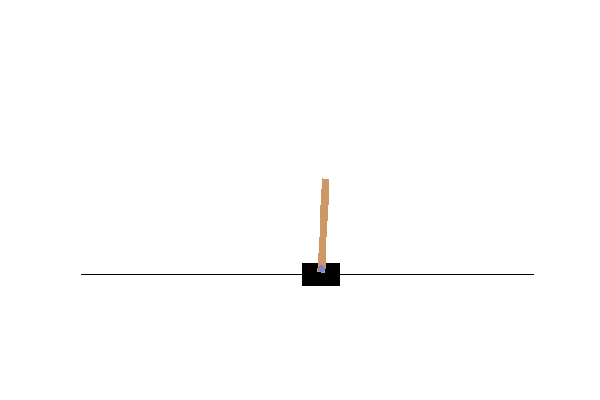
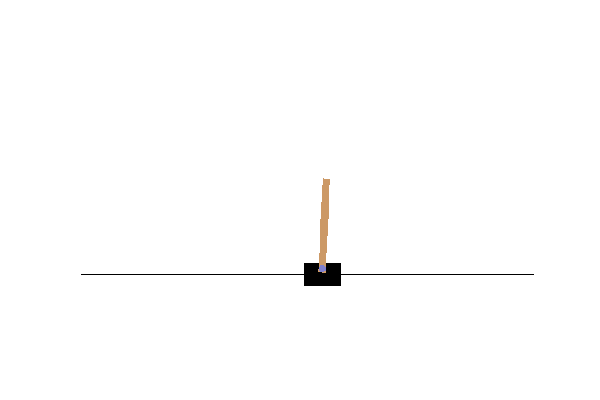
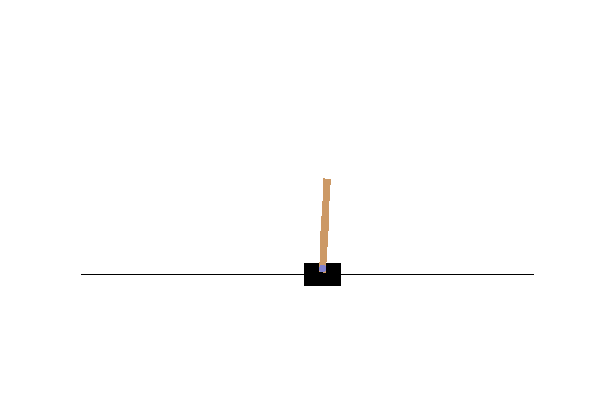
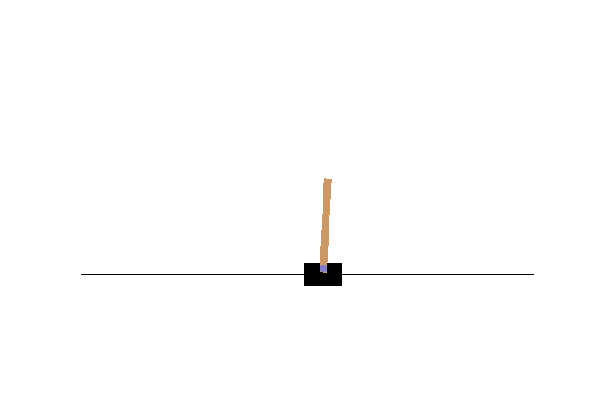
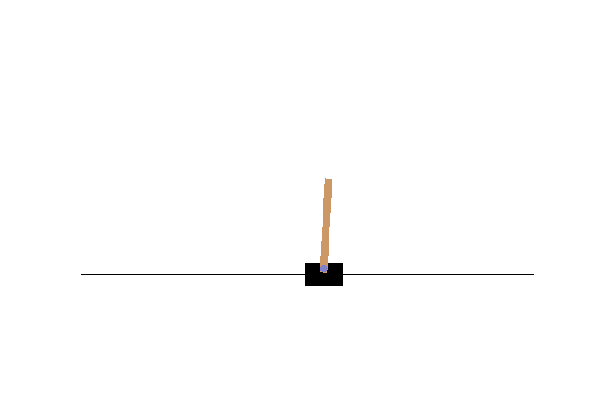
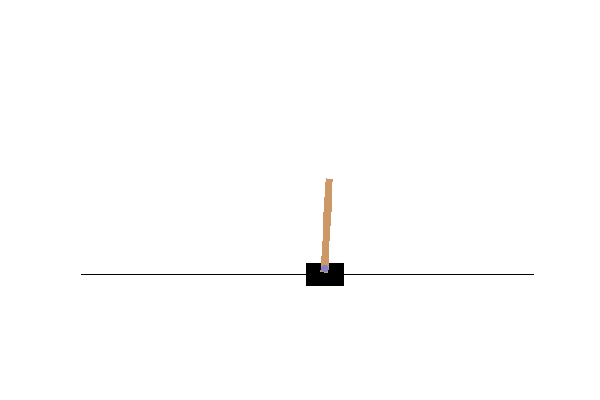
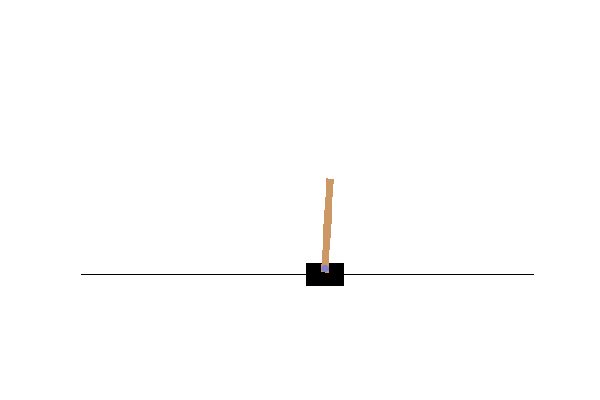
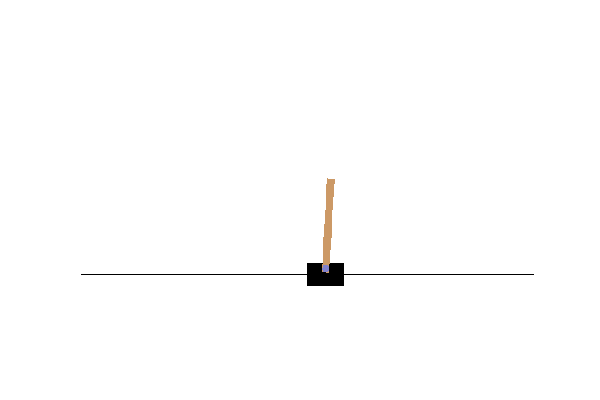
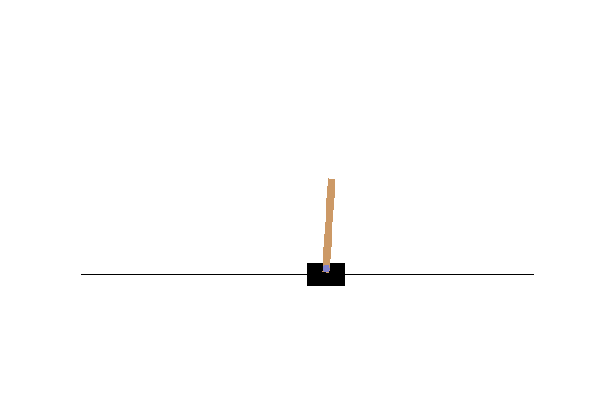
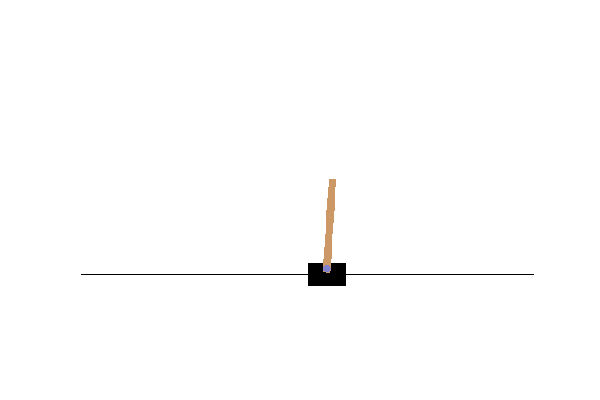
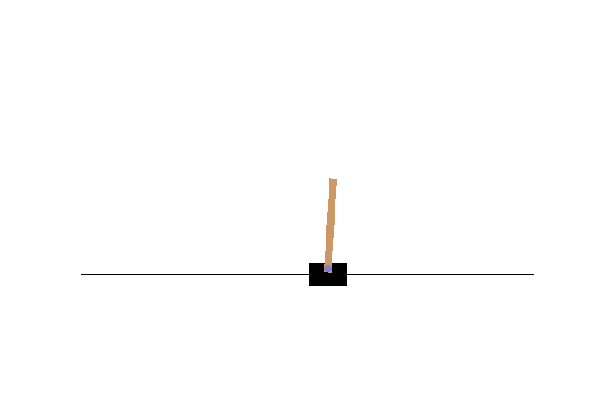
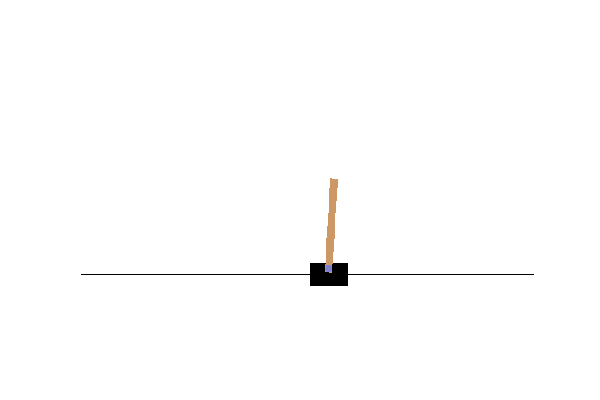
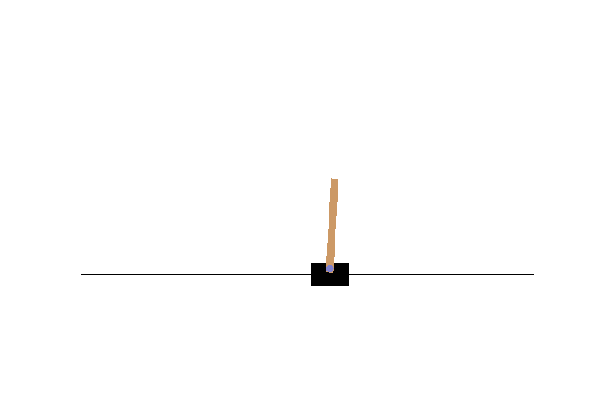
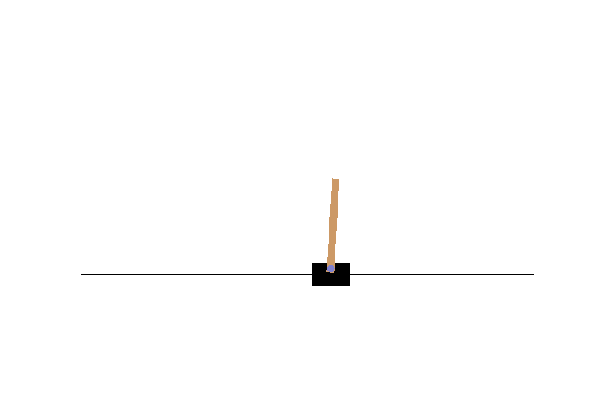
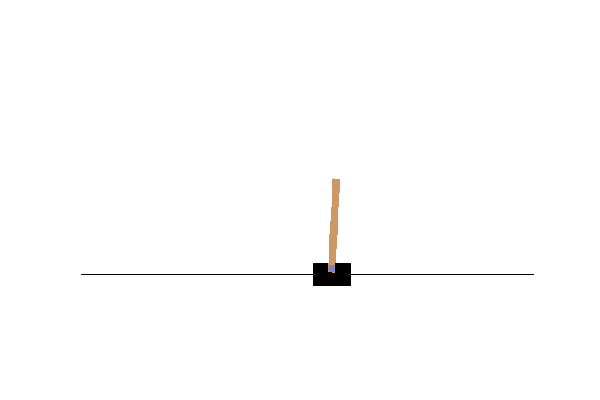
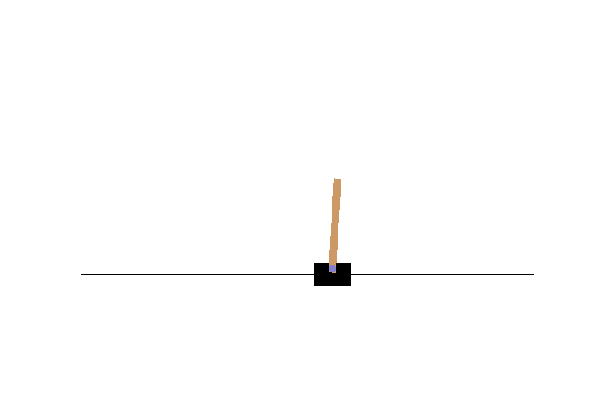
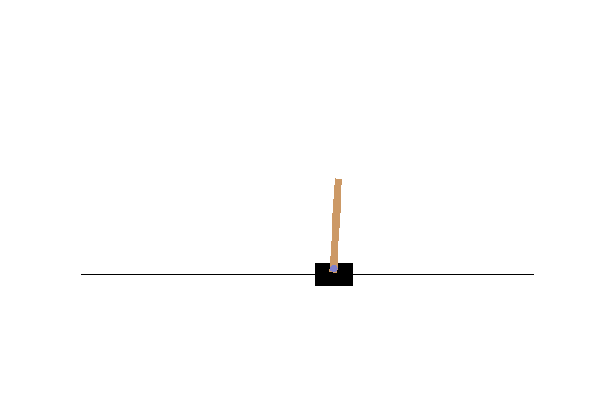
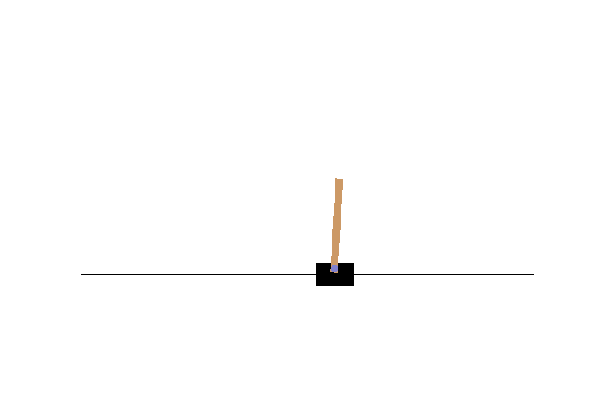
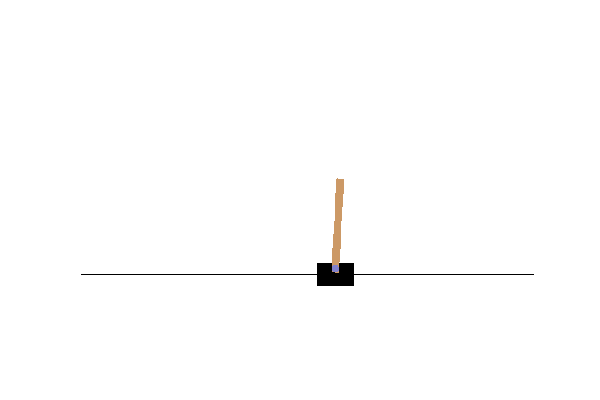
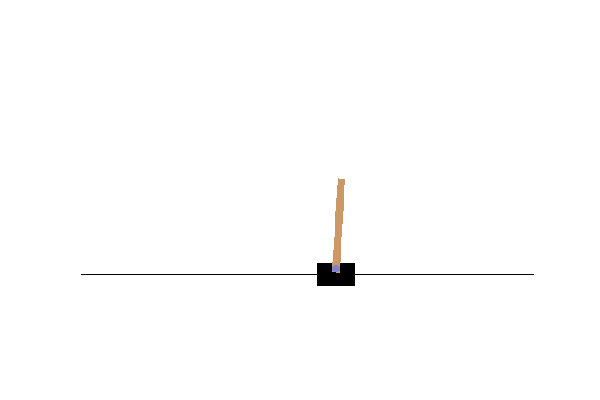
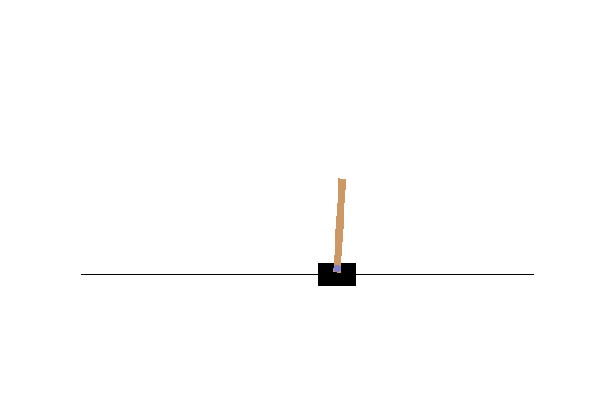
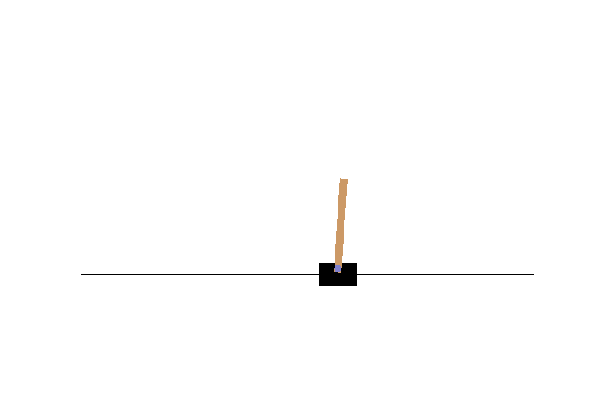
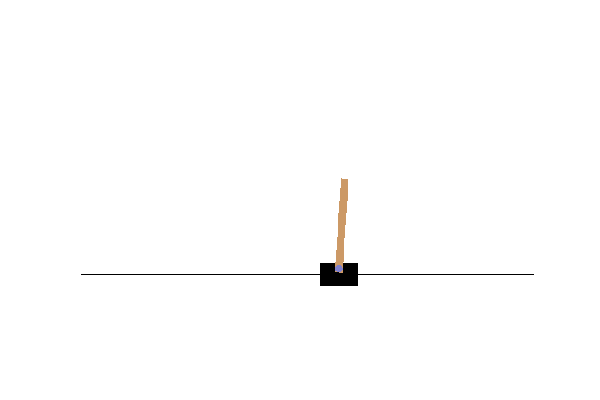
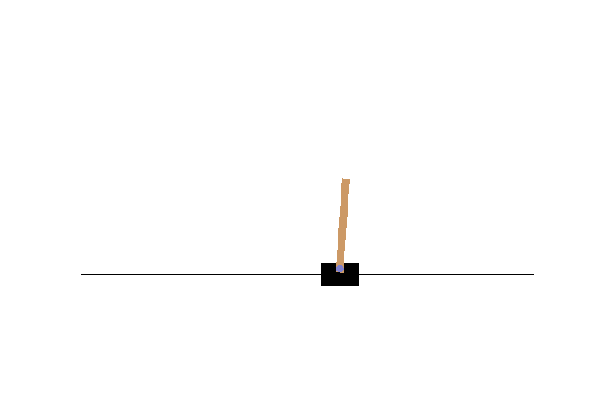
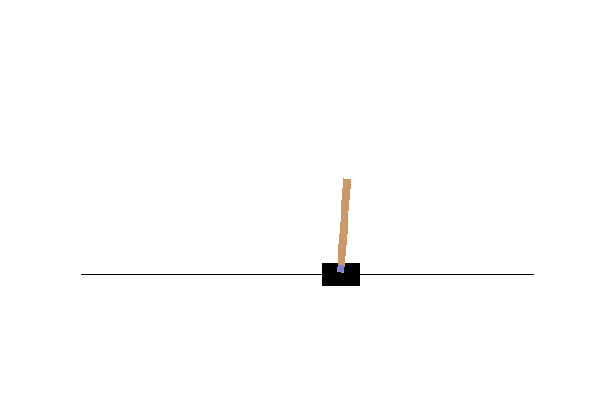
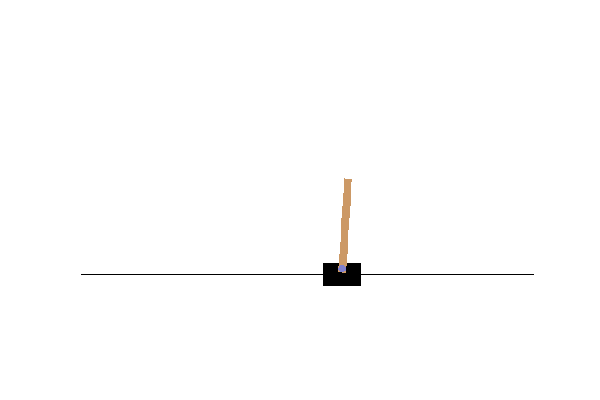
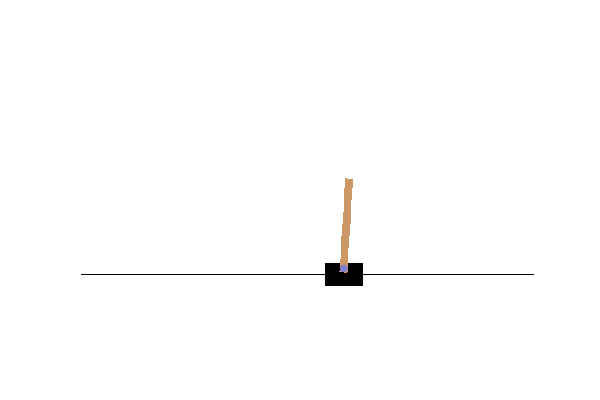
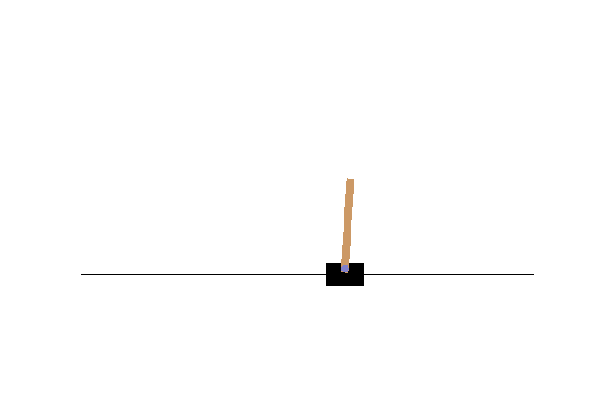
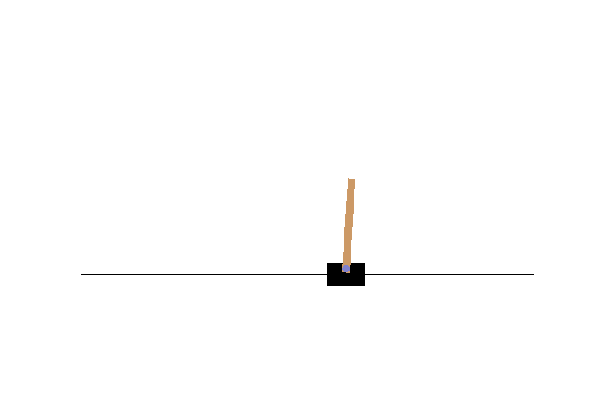
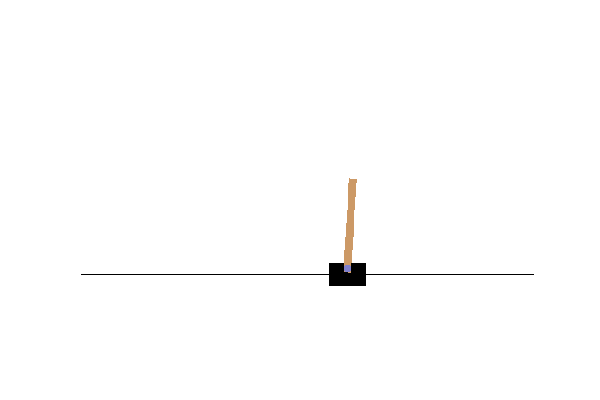
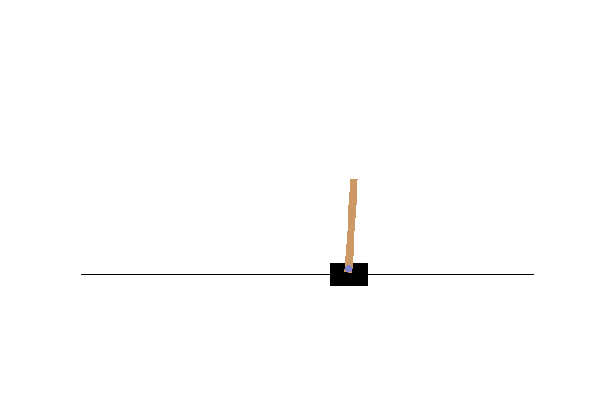
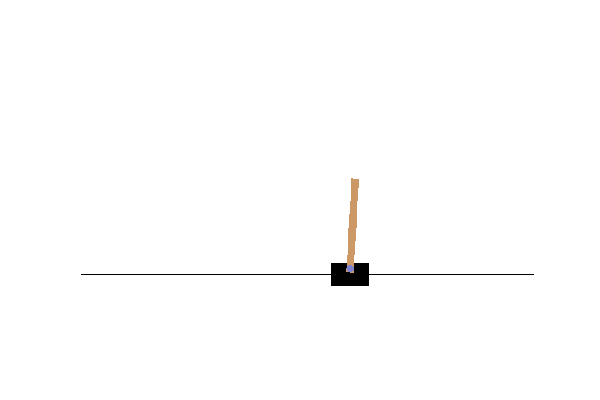
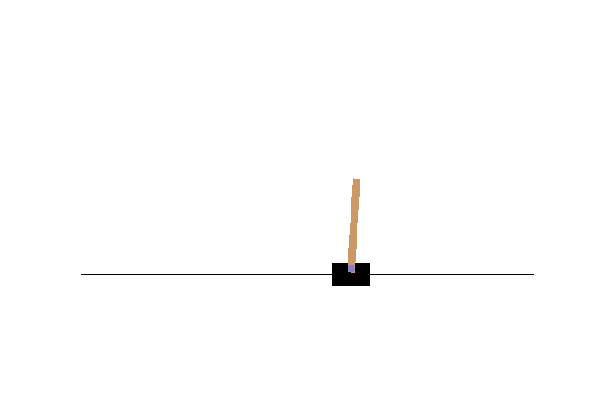
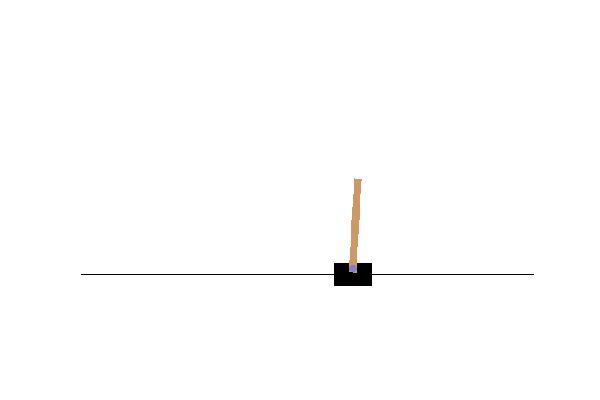
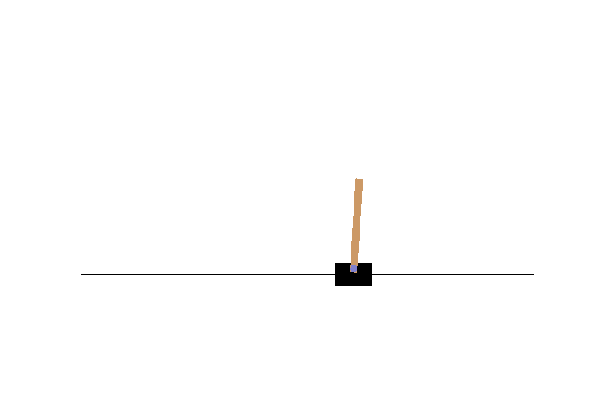
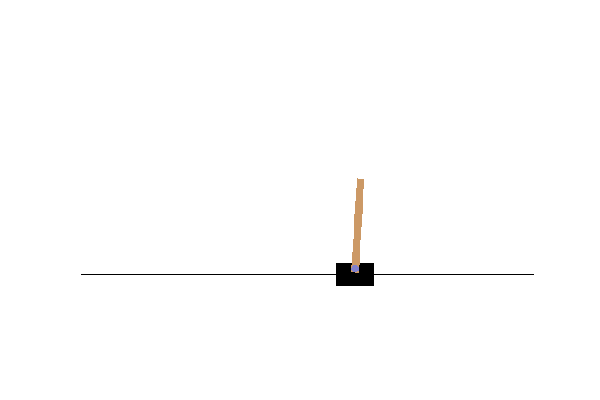
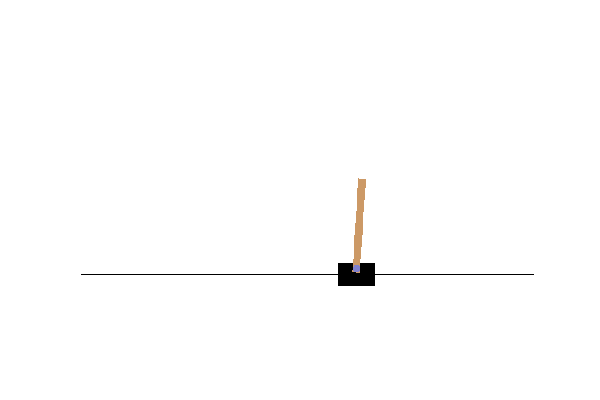
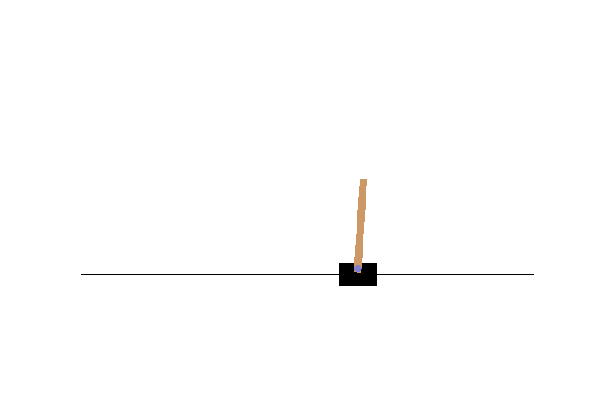
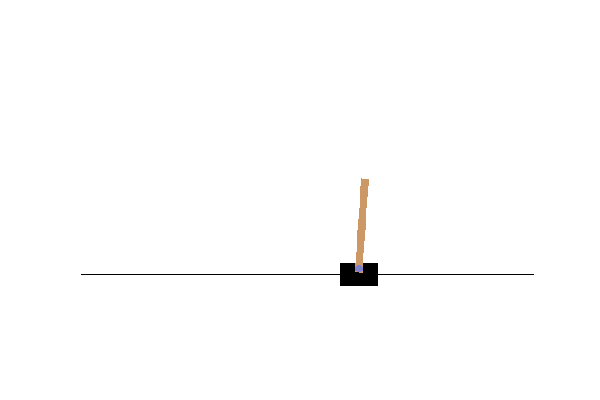
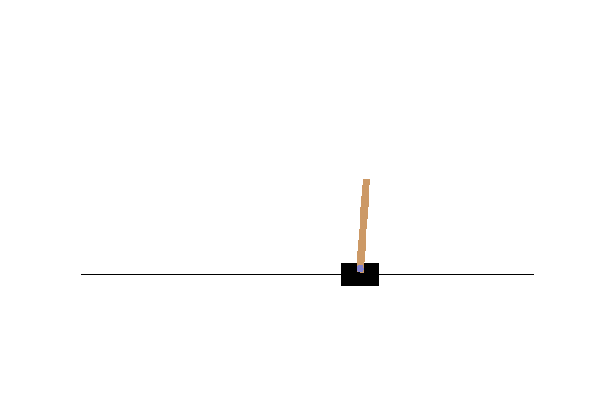
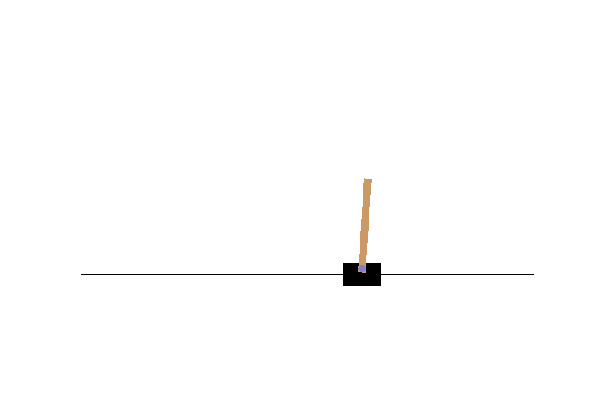
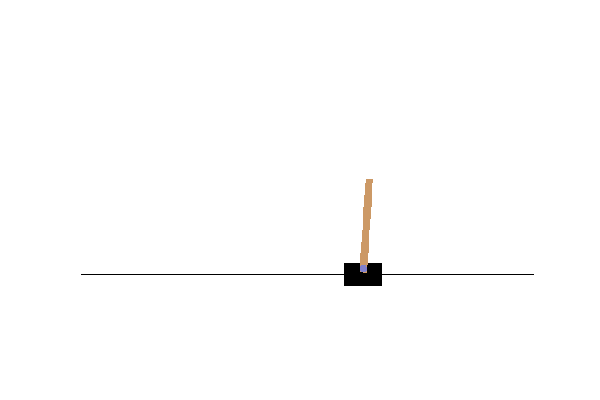
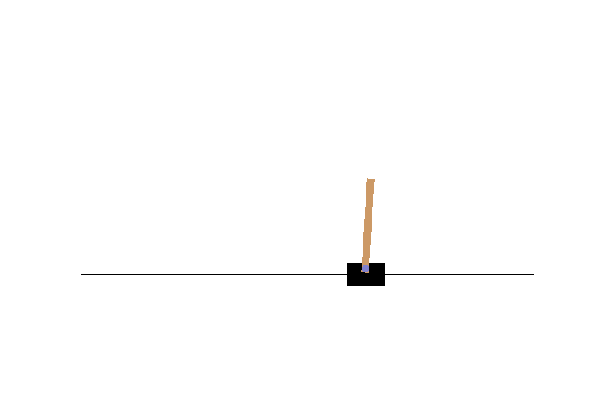
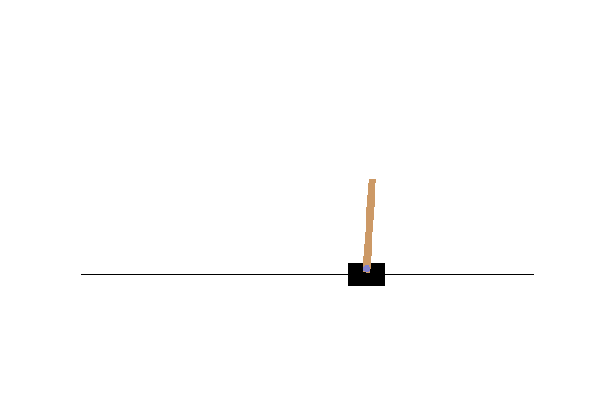
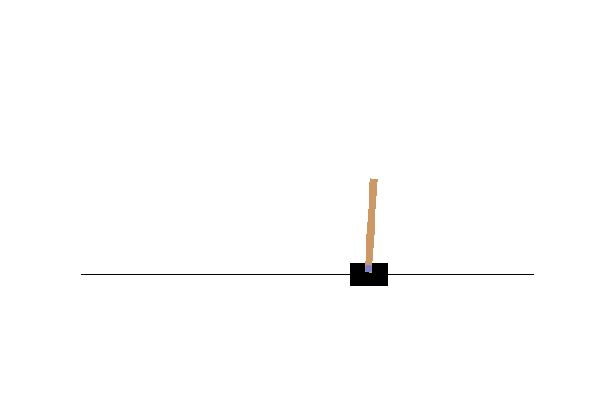
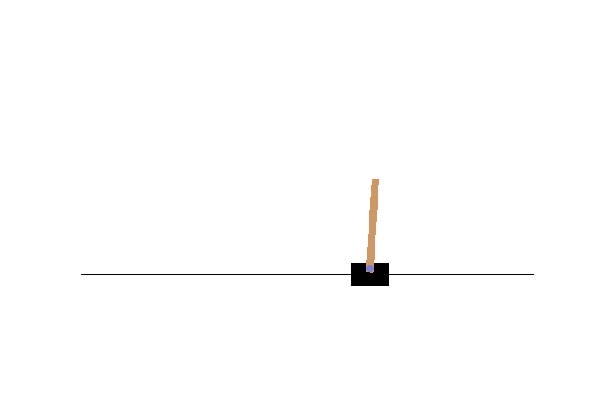
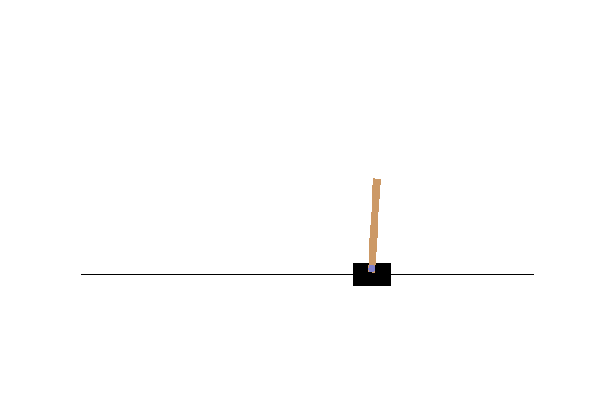
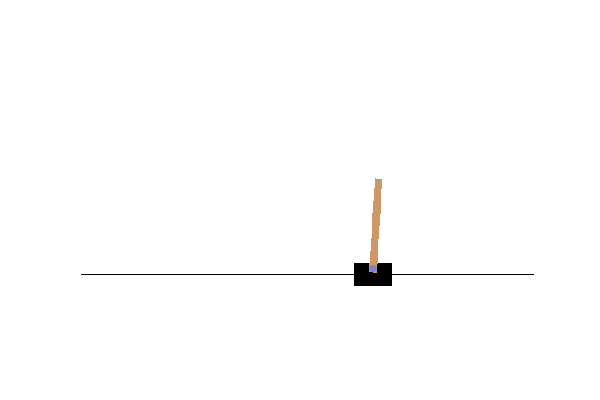
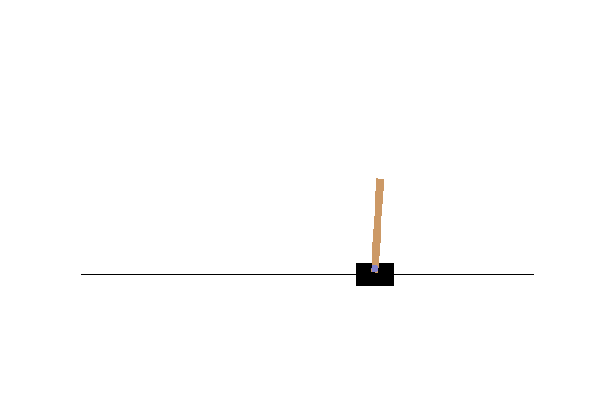
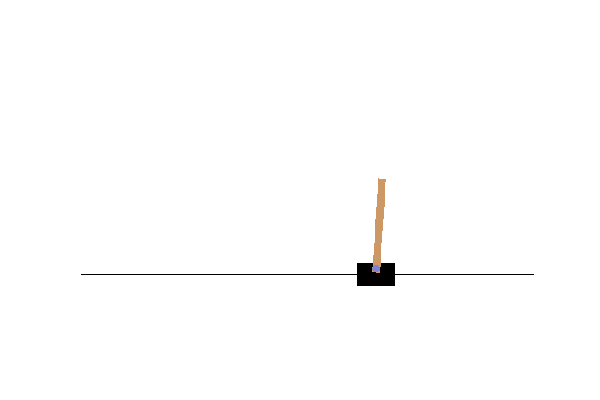
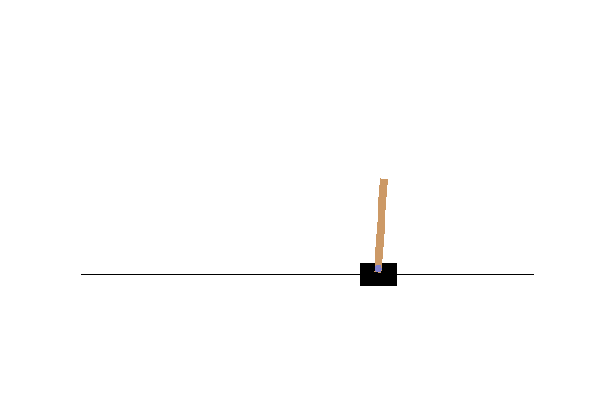
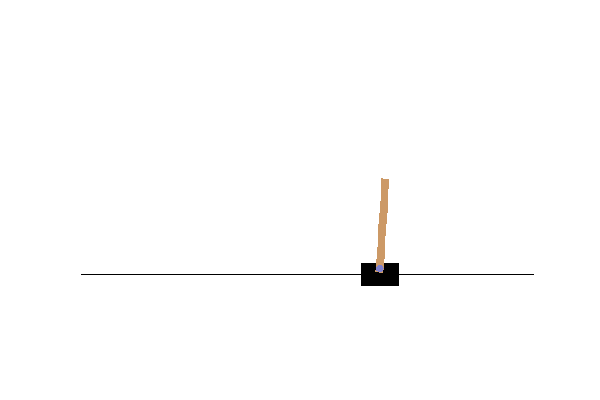
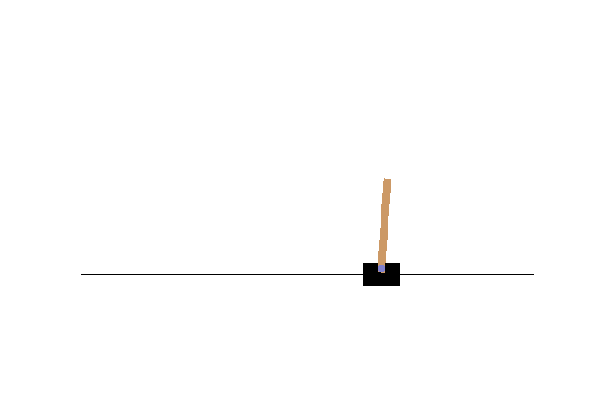
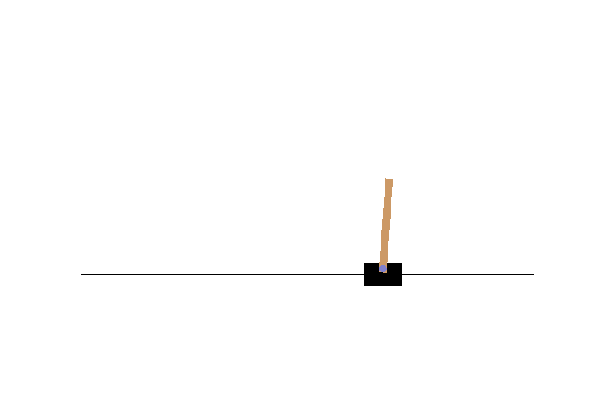
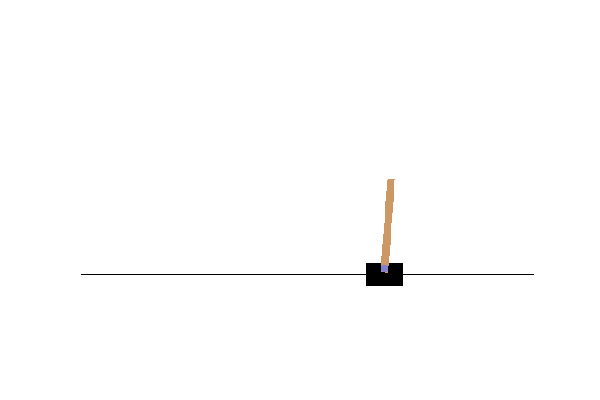
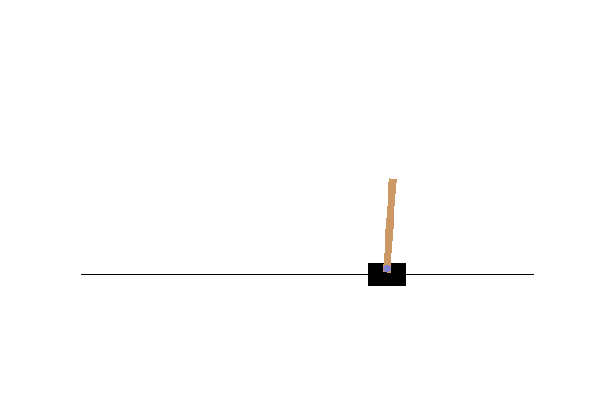
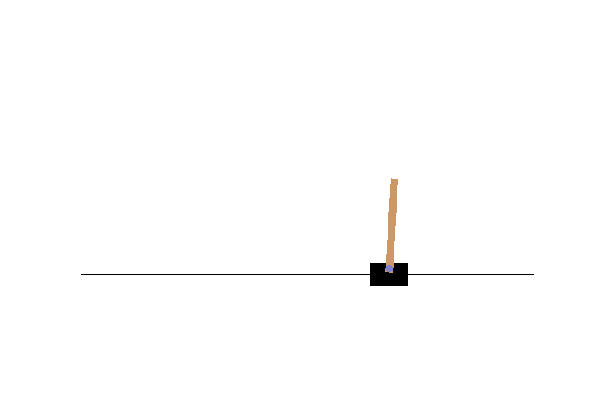
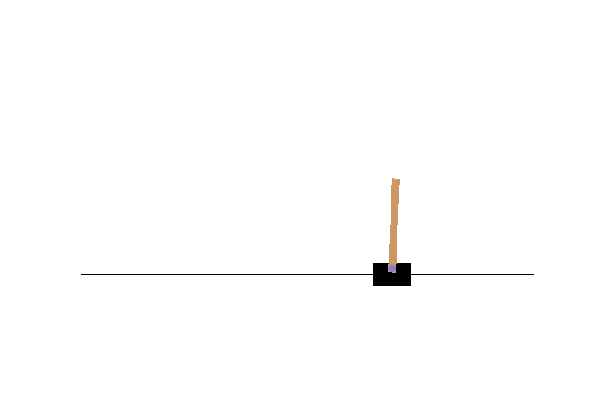
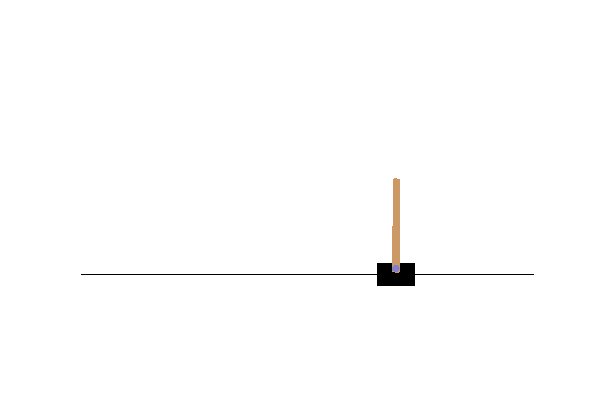
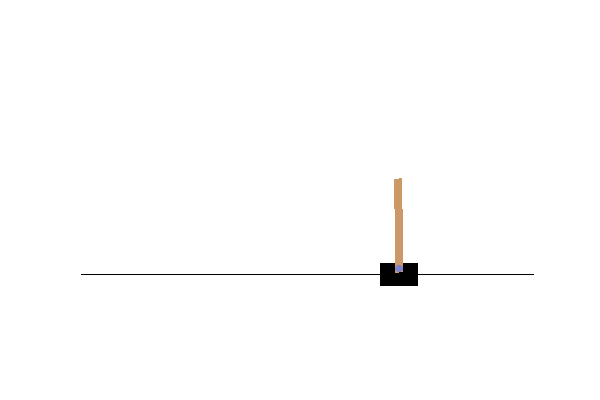
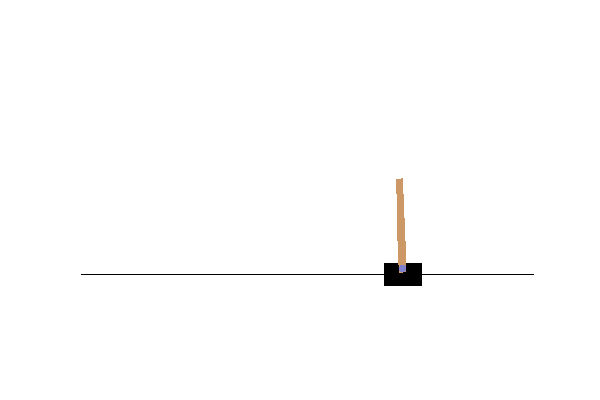
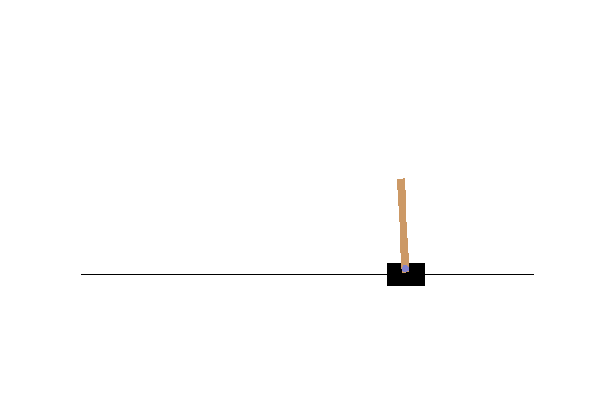
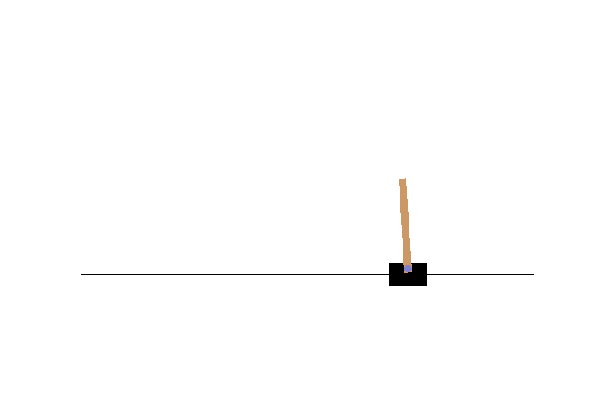
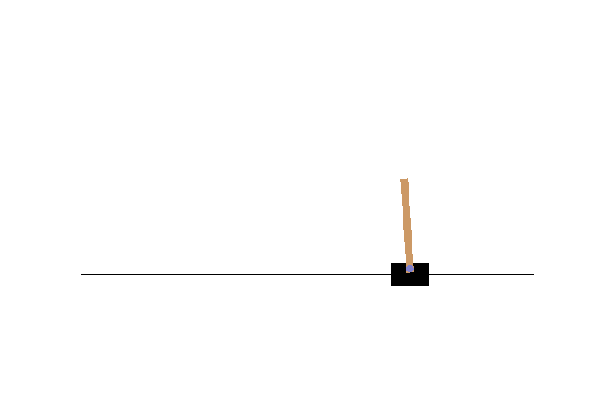
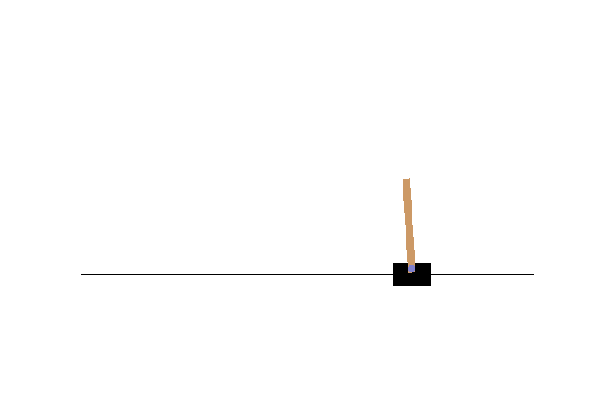
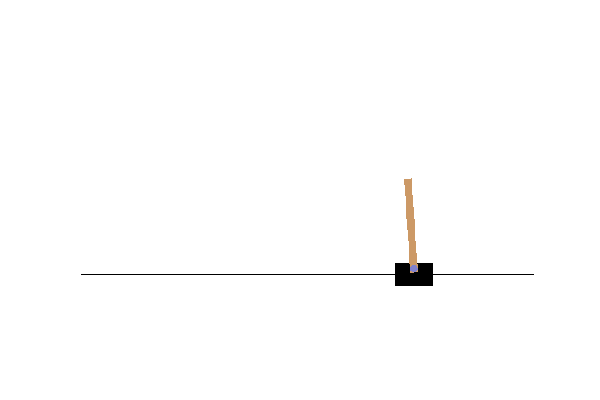
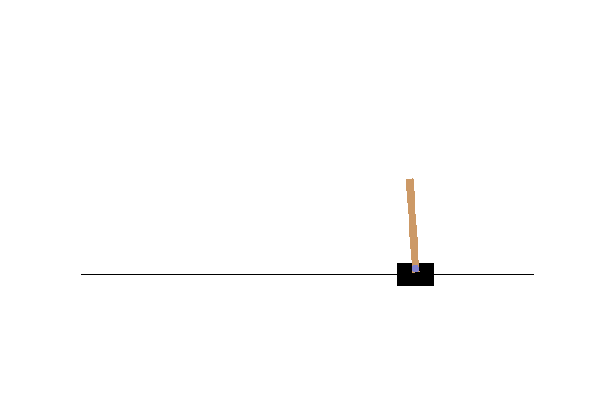
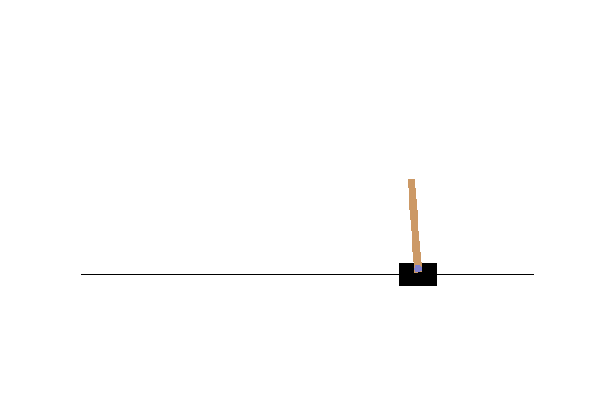
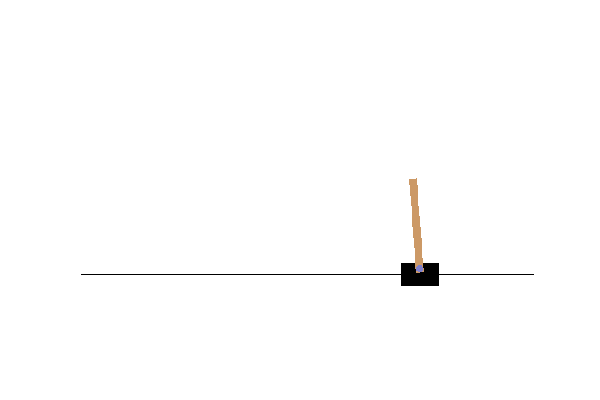
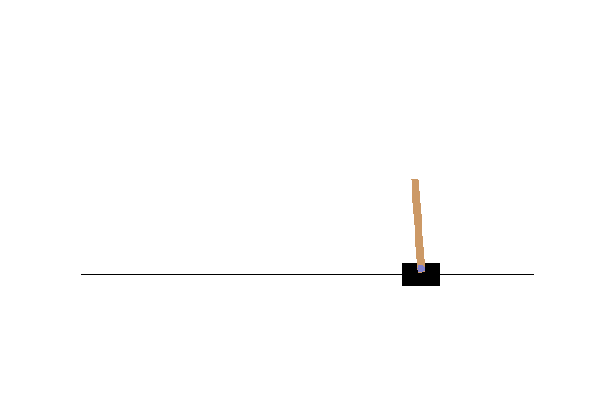
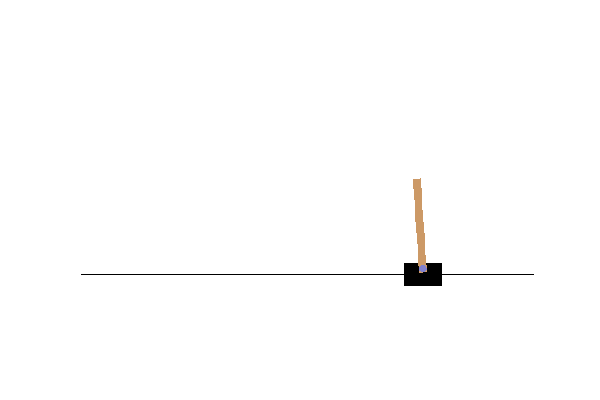
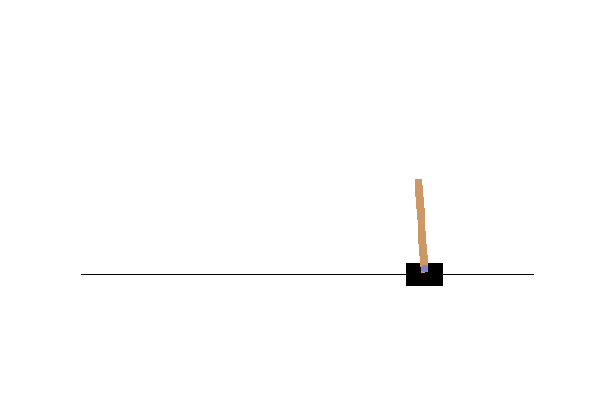
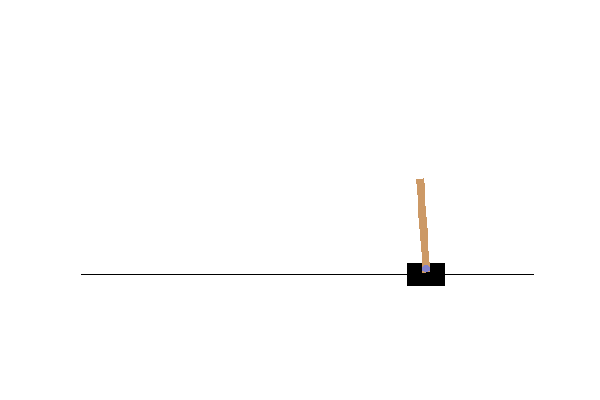
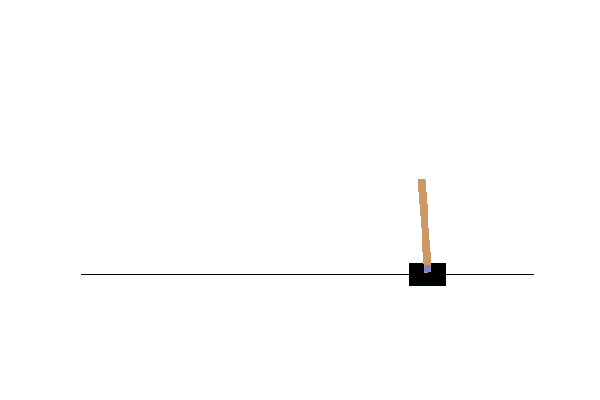
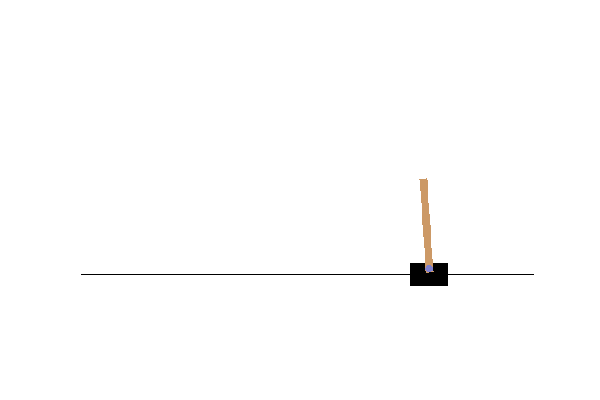
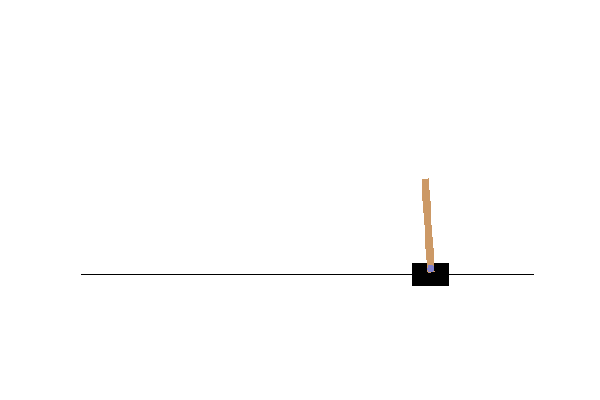
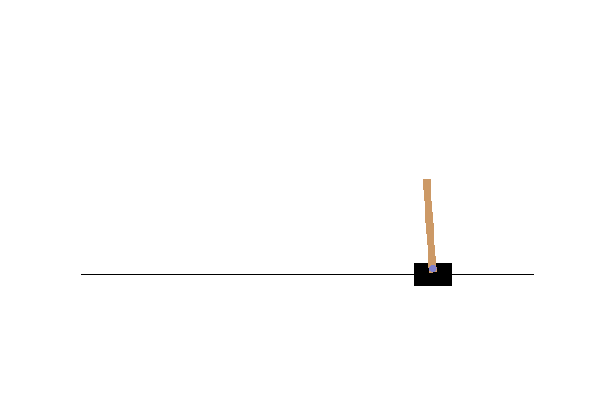
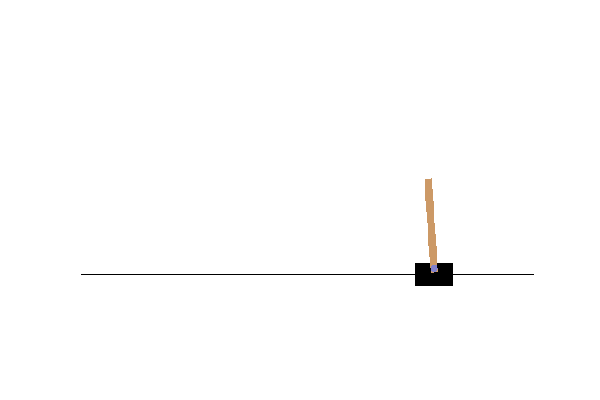
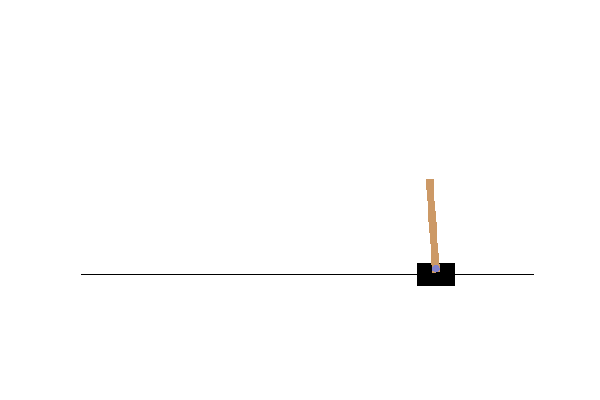
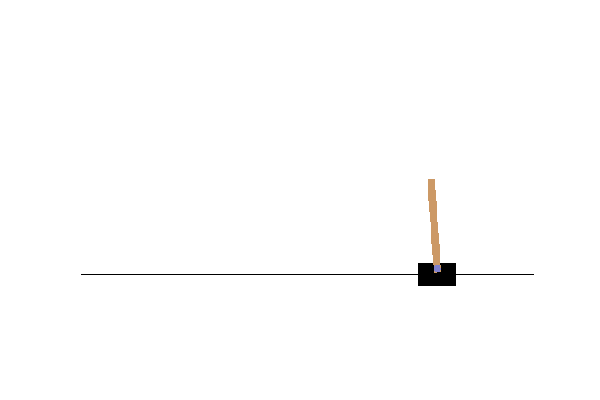
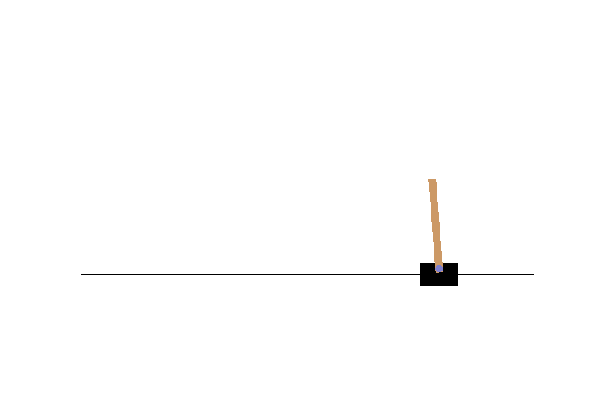
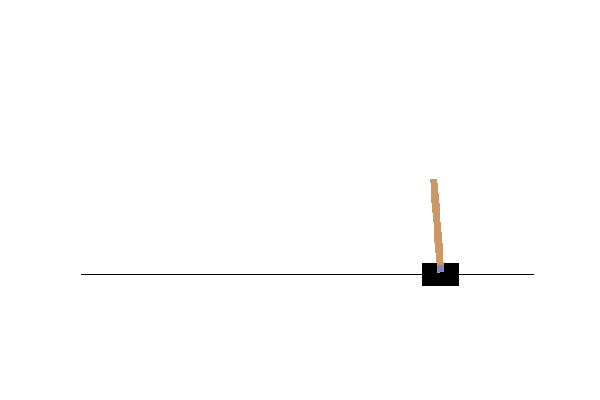
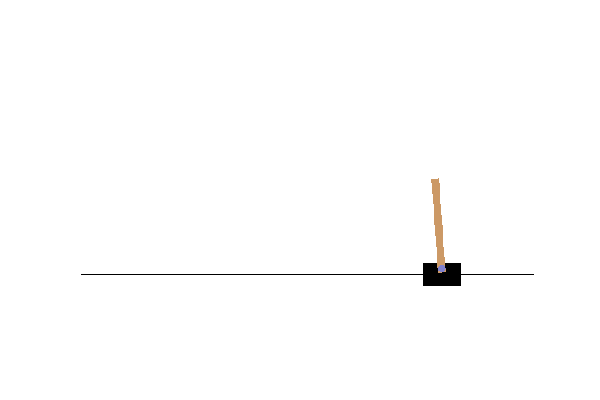
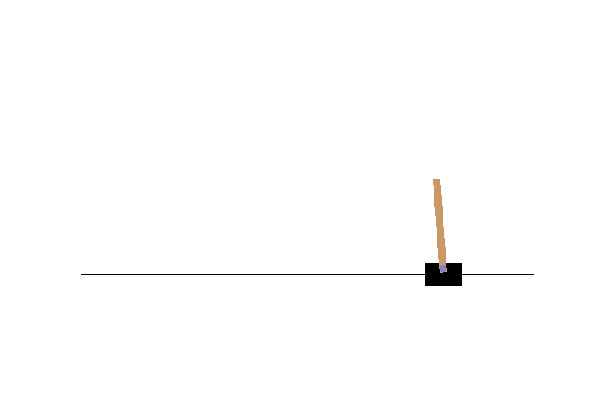
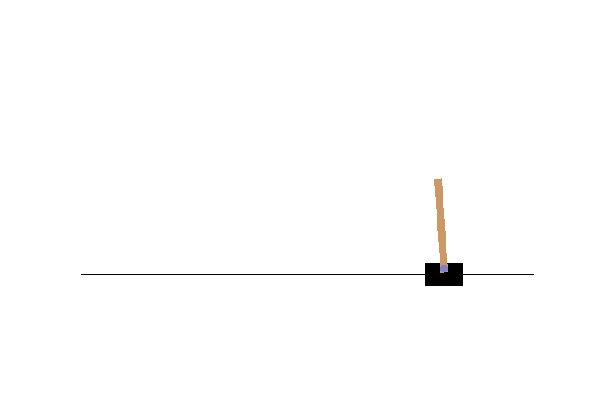
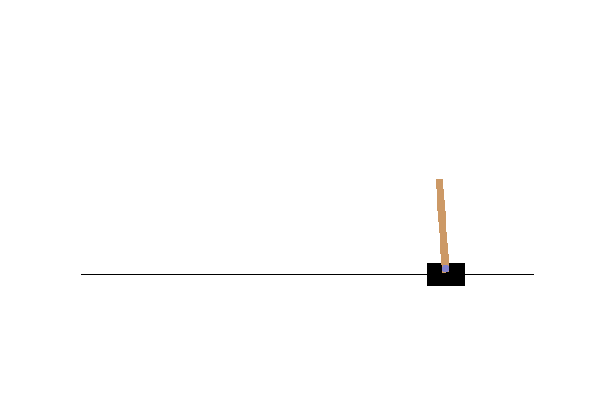
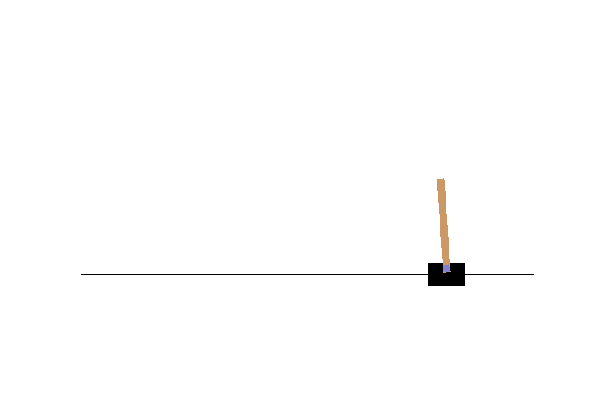
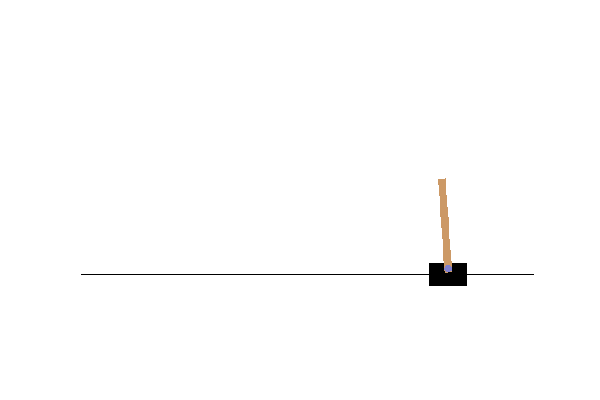
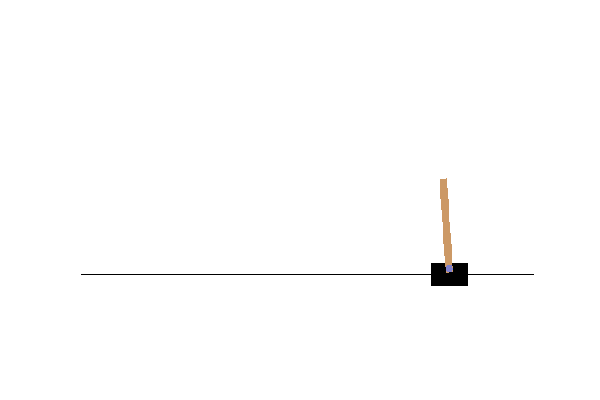
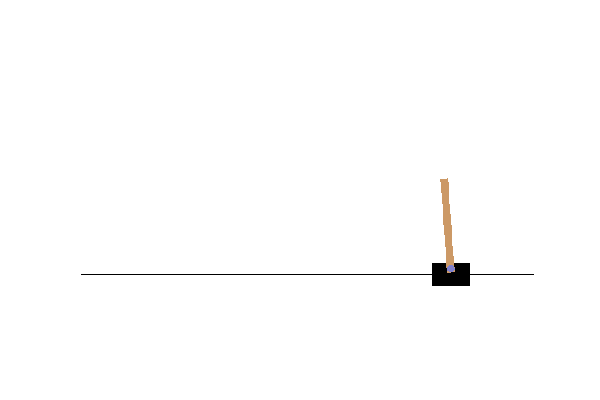
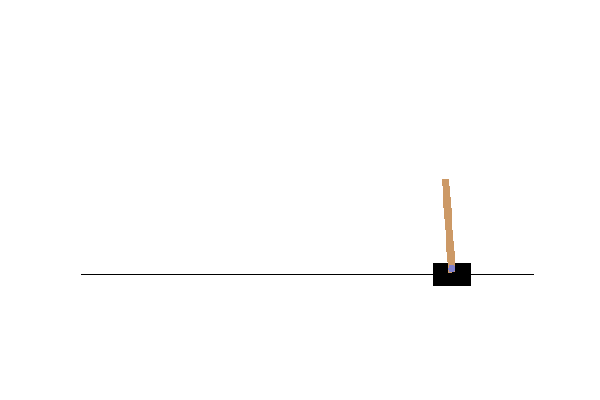
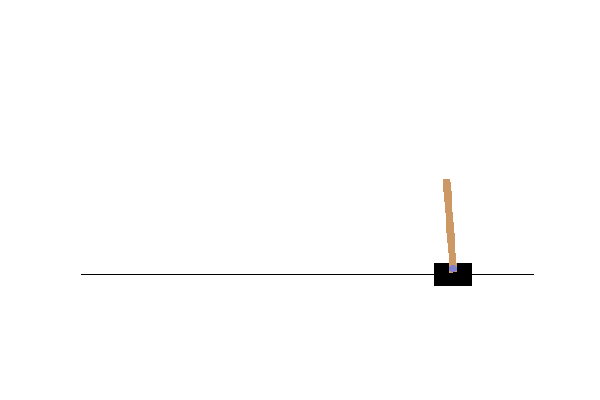
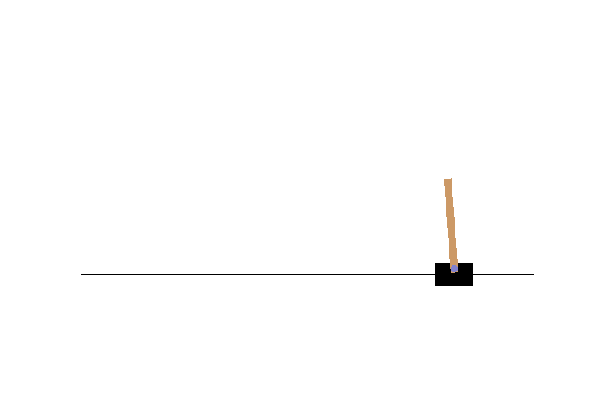
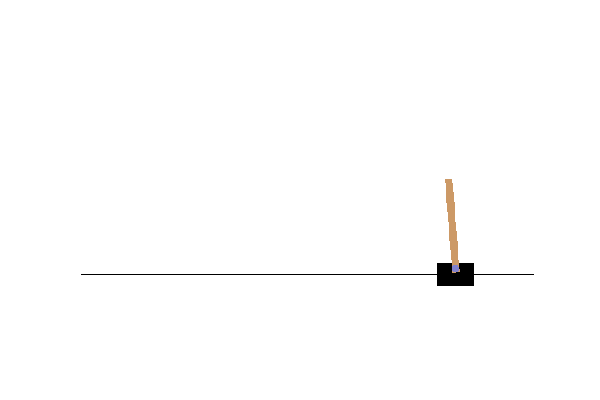
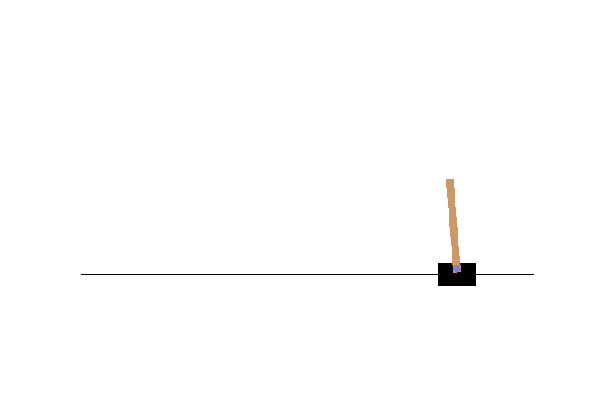
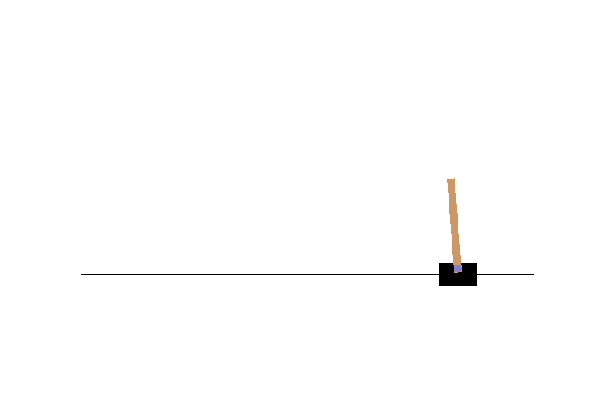
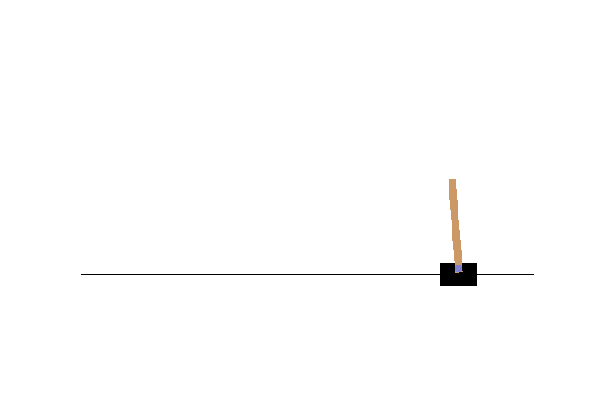
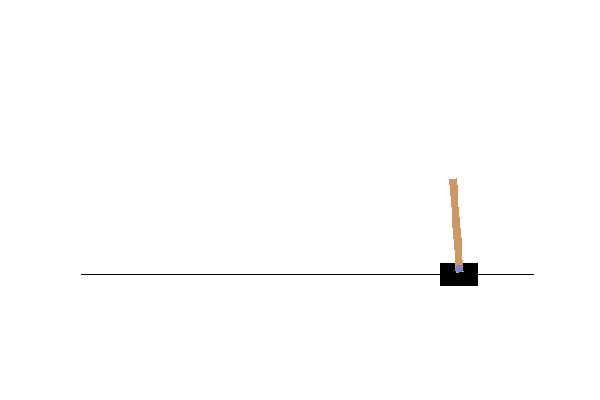
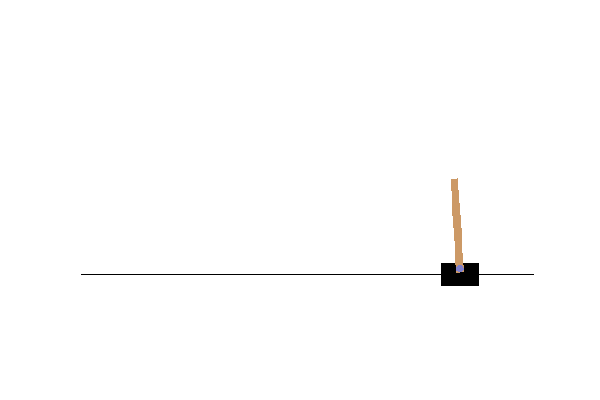
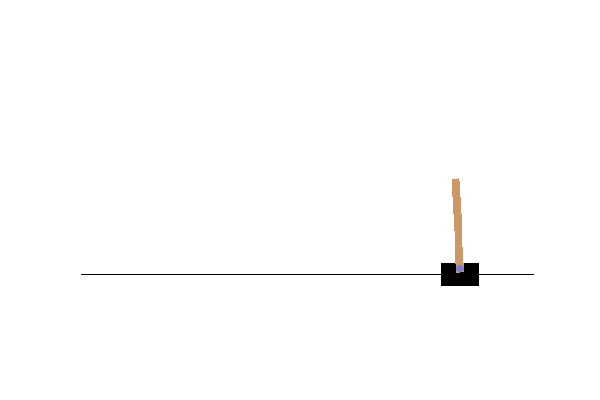
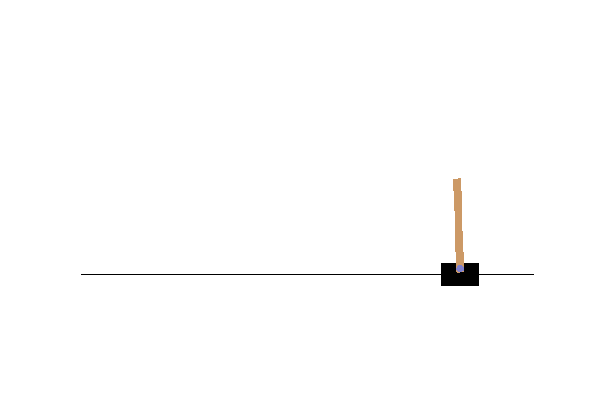
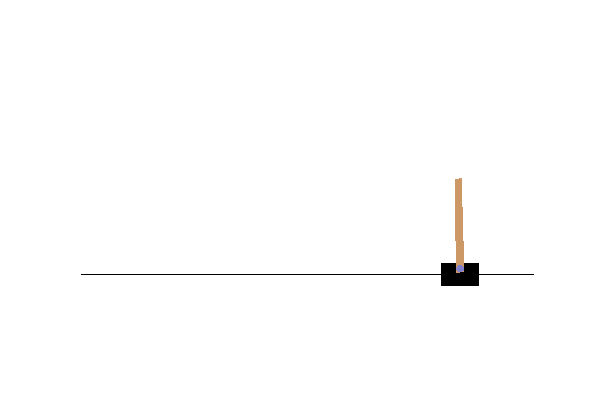
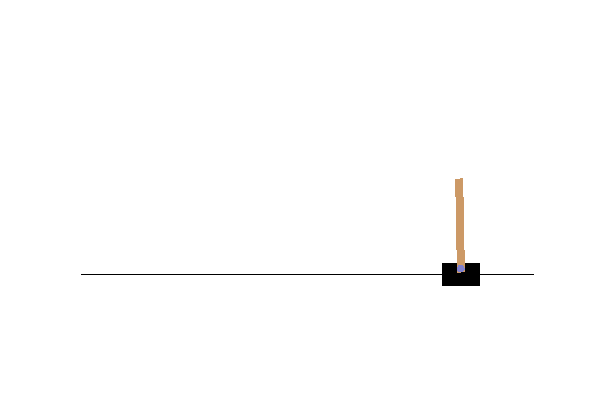
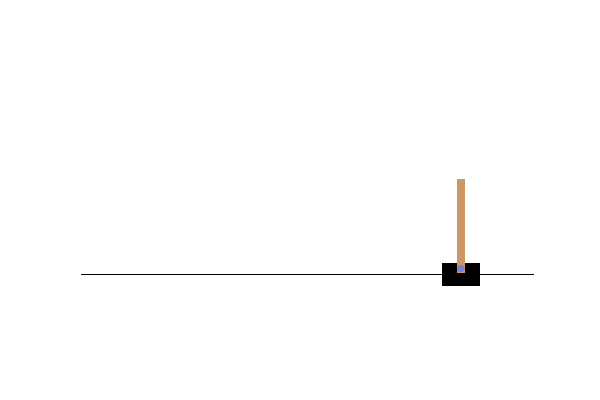
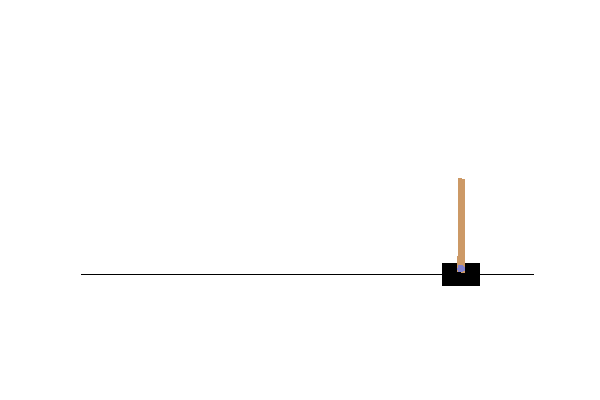
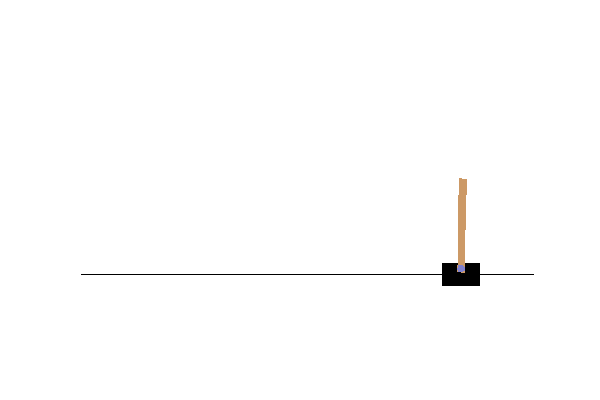
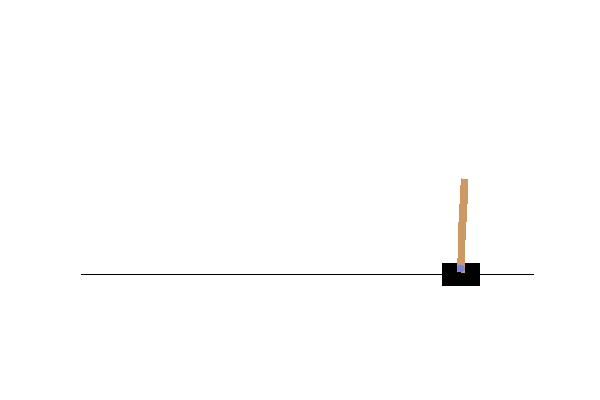
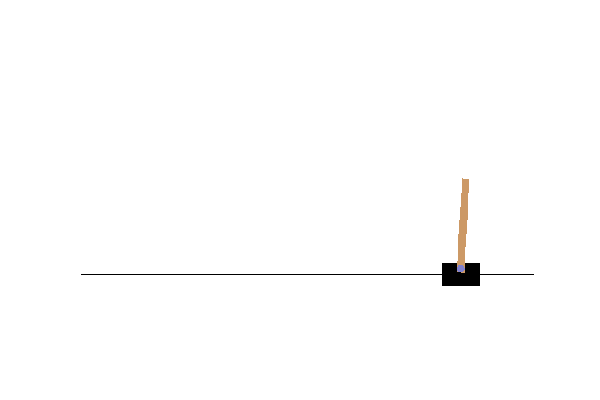
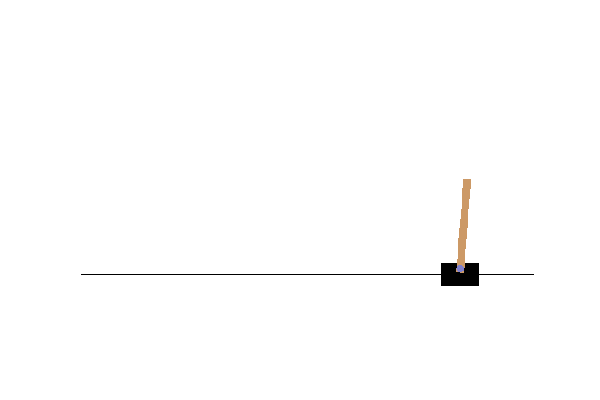
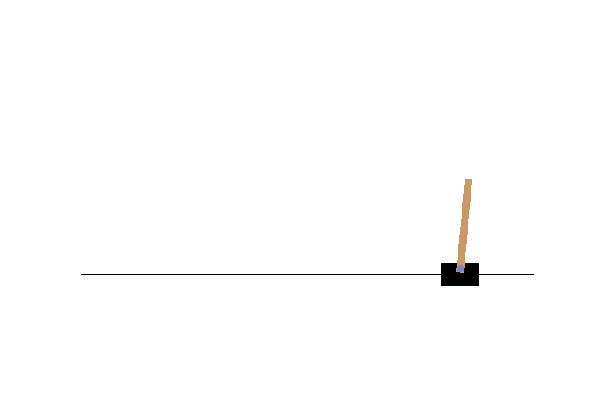
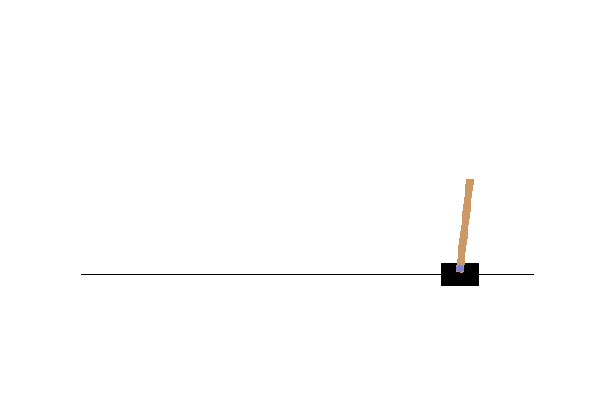
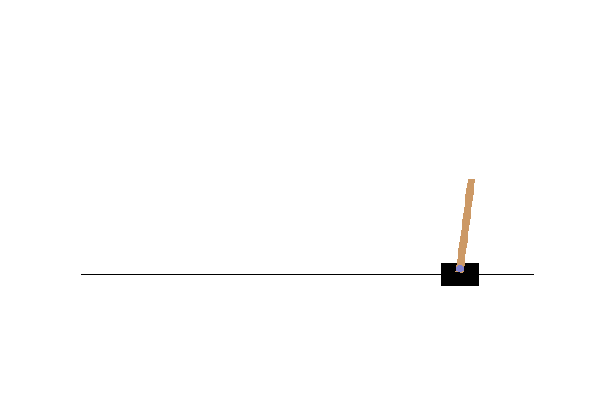
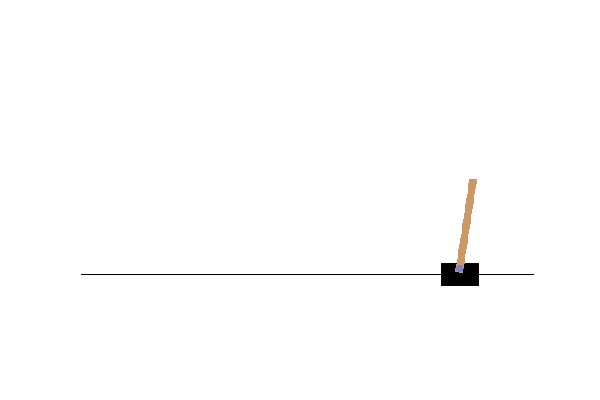
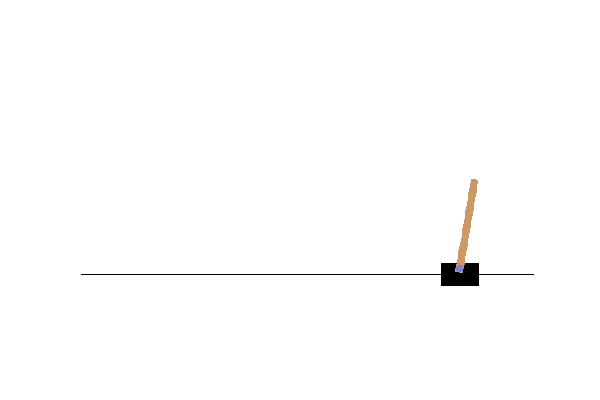
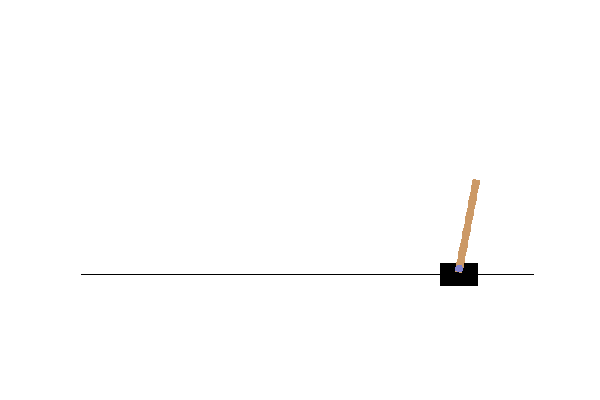

In [ ]:
cartpole_env = Environment()
cartpole_env.run()